In [1]:
import transformers
from transformers import XLNetTokenizer, XLNetModel
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from torch.nn import TripletMarginLoss

import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from scipy.stats import spearmanr
# import mplcursors
import time
import random
import pandas as pd
import numpy as np
import warnings
import re
import json
import copy
import os
import subprocess
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import average_precision_score

seed = 42

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

random.seed(seed)
np.random.seed(seed)


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression  
from scipy.stats import pearsonr, spearmanr

In [ ]:
class LateFusion(nn.Module):
    def __init__(self, in1=768, in2=200, hidden_size=500, out = 768):
        super(LateFusion, self).__init__()
        
        self.embedding1 = nn.Linear(in1, hidden_size) #BERT
        
        
        self.embedding2 = nn.Linear(in2, in2) 
        self.unet1 = nn.Linear(in2, hidden_size)
        self.unet2 = nn.Linear(hidden_size, hidden_size)
        self.unet3 = nn.Linear(hidden_size,hidden_size)
        
        
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out)
        self.relu = nn.ReLU()


    def forward(self, x1, x2):

        #For BERT
        x1 = self.embedding1(x1)
        x1 = self.relu(x1)
                
        
        #For other modalities
        x2 = self.embedding2(x2)
        x2 = self.relu(x2)
        
        x2 = self.unet1(x2)
        x2 = self.relu(x2)
        
        x2 = self.unet2(x2)
        x2 = self.relu(x2)
        
        x2 = self.unet3(x2)
        x2 = self.relu(x2)

        
        z = torch.cat((x1, x2), dim=1)
        z = self.fc1(z)   
        z = self.relu(z)
        z = self.fc2(z)
        z = self.relu(z)
        
        return z





class FineTunedBERT(nn.Module):

    def __init__(self, pool="mean", model_name= "bert-base-cased", bert_state_dict=None,
                 task_type = None, n_labels = None, drop_rate = None,
                 gene2vec_flag=True, gene2vec_hidden = 200, device ="cuda"):
        
        """
            task_type : regression or classification.
        
        """
      
        super(FineTunedBERT, self).__init__()

#         assert (task_type == 'unsupervised' and n_labels == 1) or (task_type == 'regression' and n_labels == 1) or (task_type == 'classification' and n_labels>1) or (task_type == 'multilabel' and n_labels>1), \
#             f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"  

#         assert gene2vec_flag is not None, f"gene2vec_flag cannot be None: {gene2vec_flag}"

        
        self.model_name = model_name
        self.pool = pool
        
        
        if "xlnet" in model_name:
            self.bert = XLNetModel.from_pretrained(model_name).to(device)
        
        else:
            if bert_state_dict: 
                self.bert = AutoModel.from_pretrained(model_name)
                self.bert.load_state_dict(bert_state_dict) #.to(device)
            else:
                self.bert = AutoModel.from_pretrained(model_name)#.to(device)
                
        
#         layers_to_train = ["encoder.layer.11", "encoder.layer.10", "encoder.layer.9",
#                            "encoder.layer.8","pooler"]
        for name, param in self.bert.named_parameters():

            if name.startswith("encoder.layer.11") or name.startswith("encoder.layer.10") or\
            name.startswith("encoder.layer.9") or name.startswith("pooler") or\
            name.startswith("encoder.layer.8") : 
                param.requires_grad = True
            else:
                param.requires_grad = False
    
        
        
        self.bert_hidden = self.bert.config.hidden_size
        self.gene2vecFusion = LateFusion(in1=self.bert_hidden,
                                         in2=gene2vec_hidden,
                                         hidden_size=500,
                                         out = self.bert_hidden)
        
        if task_type.lower() == "classification":
            
            assert  n_labels > 1, f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"
            self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, n_labels))
#             if gene2vec_flag:
#                 self.pipeline = nn.Sequential(
#                     nn.Linear(self.bert_hidden+gene2vec_hidden, n_labels)
#                 )
                
#             else:
#                 self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, n_labels))
    
        elif task_type.lower() == "multilabel":
            assert  n_labels > 1, f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"
            self.pipeline = nn.Sequential(
                    nn.Linear(self.bert_hidden, n_labels),
                    nn.Sigmoid()
                )

            
#             assert  n_labels > 1, f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"
            
#             if gene2vec_flag:
#                 self.pipeline = nn.Sequential(
#                     nn.Linear(self.bert_hidden+gene2vec_hidden, n_labels),
#                     nn.Sigmoid()
#                 )
                
#             else:
#                 self.pipeline = nn.Sequential(
#                     nn.Linear(self.bert_hidden, n_labels),
#                     nn.Sigmoid()
#                 )

        elif task_type.lower() == "regression":
            assert  n_labels == 1, f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"
            self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, 1))
            

#             if gene2vec_flag:
#                 self.pipeline = nn.Sequential(
#                 nn.Linear(self.bert_hidden+gene2vec_hidden, 1))
                
#             else:            
#                 self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, 1))
        
        elif task_type.lower() =="interaction":
            if gene2vec_flag:
                raise ValueError(f"gene2vec_flag must be False when task_type is set to {task_type}: {gene2vec_flag=}")
                
            else:      
                self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, 1))
            
        
        elif task_type.lower() == "unsupervised":
            self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, 1))
            #No need for an assert, labels will not be used during unsupervised.

#             if gene2vec_flag:
#                 raise ValueError(f"gene2vec_flag must be False when task_type is set to {task_type}: {gene2vec_flag=}")
                
#             else:      
#                 self.pipeline = nn.Sequential(nn.Linear(self.bert_hidden, 1))

        else:
            raise ValueError(f"Key Error task_type : {task_type} ")
          
    def forward(self, input_ids_, attention_mask_, gene2vec=None):
        
        
        # retrieving the hidden state embeddings
        if "xlnet" in self.model_name:
            output = self.bert(input_ids = input_ids_,
                               attention_mask=attention_mask_)

            hiddenState, ClsPooled = output.last_hidden_state, output.last_hidden_state[:,0, :]

        else:
            hiddenState, ClsPooled = self.bert(input_ids = input_ids_,
                                               attention_mask=attention_mask_).values()

        
        # perform pooling on the hidden state embeddings
        if self.pool.lower() == "max":
            embeddings = self.max_pooling(hiddenState, attention_mask_)
            
        elif self.pool.lower() == "cls":
            embeddings = ClsPooled
                
        elif self.pool.lower() == "mean":
            embeddings = self.mean_pooling(hiddenState, attention_mask_)

        else:
            raise ValueError('Pooling value error.')
        
        
        if gene2vec is not None:
            embeddings = self.gene2vecFusion(embeddings, gene2vec)
            #embeddings = torch.cat((embeddings, gene2vec), dim=1)
      

        return embeddings, hiddenState, self.pipeline(embeddings)

    def max_pooling(self, hidden_state, attention_mask):
        
        #CLS: First element of model_output contains all token embeddings
        token_embeddings = hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        
        pooled_embeddings = torch.max(token_embeddings, 1)[0]
        return pooled_embeddings
    
    def mean_pooling (self, hidden_state, attention_mask):
        
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
        pooled_embeddings = torch.sum(hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
        
        return pooled_embeddings

def process_sent(sent):

    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    text = " ".join(captured_content)
    text = re.sub(pattern2, "", text)
    text = re.sub(pattern3, "####", text)
    text = re.sub(pattern4, "", text)
    text = re.sub(pattern5, "", text)
    text = re.sub(pattern6, r"\1 ", text)
    text = re.sub(pattern7, "", text)
    text = re.sub(r'\s+', ' ', text)
    
    return text


class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(MultiLabelFocalLoss, self).__init__()
        
        self.alpha = nn.Parameter(torch.tensor(0.25, requires_grad=True, device="cuda"))  
        self.gamma = nn.Parameter(torch.tensor(2.0, requires_grad=True, device="cuda"))  

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        return F_loss.mean()


def plot_latent(latents, labels, epoch, class_map = None,
                task_name= "subloc", validation_type="train", model_type="bert"):
    
    tsne = TSNE(n_components=2)
    scaler = StandardScaler()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latents_tsne = tsne.fit_transform(latents)
    

    if class_map is not None:
        
        for i, class_label in enumerate(np.unique(labels)):
            class_indices = labels == class_label
            cl = class_map[class_label]
            plt.scatter(latents_tsne[class_indices, 0],
                        latents_tsne[class_indices, 1],
                        label=f'{cl}')
        plt.legend()
        
    else:
        plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1])

        

    plt.title(f'Epoch {epoch}')
    task_path = f"data/{task_name}/{model_type}/"
    if not os.path.exists(task_path):
        os.makedirs(task_path)

    validation_path = f"{task_path}/{validation_type}"
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)

    plt.savefig(f"{validation_path}/latent_{epoch}.png")
    plt.close()


def train(loader, model, loss_fn, optimizer, task_type= None,
          gene2vec_flag = True, device = "cuda",
          threshold=0.5 ):
    """
        task : conservation , sublocation, solubility
        task_type : regression or classification
    
    
    """
    
    train_loss = 0
    latents  = []

    total_preds = []
    total_labels = []
    probabilities = []
    
    # conservation , sublocation, solubility
   

    
    model.train()
    for batch in loader: 

        
        if gene2vec_flag:
            batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)
            
            
        else:
            batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks)

        
        
        if task_type == "regression":
            
            preds = preds.squeeze().float()
            labels = labels.squeeze().float()
            
            loss = loss_fn(preds, labels) 
            
            
            total_preds.extend(preds.cpu().detach())
            total_labels.extend(labels.cpu().detach())        

        
        elif task_type == "classification":
            # print(preds.shape, labels.shape)
            # print(preds, labels)
            
            loss = loss_fn(preds, labels)
            
            total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
            total_labels.extend(labels.type(torch.int).to('cpu').numpy())
            probas = F.softmax(preds, dim=1)
            probabilities.extend(probas.detach().cpu().numpy())

        
        
        elif task_type == "multilabel":

            preds = preds.to(torch.float32)
            labels = labels.to(torch.float32)

            loss = loss_fn(preds, labels)
            
            total_labels.extend(labels.cpu().type(torch.int).numpy().tolist())
            total_preds.extend((preds > 0.5).type(torch.int).cpu().numpy().tolist())
            probas = torch.sigmoid(preds)
            probabilities.extend(probas.detach().cpu().numpy())
            
        
        train_loss += loss.item()

        
        #Aggregation
        embeddings = torch.tensor(embeddings.cpu().detach().numpy())
        latents.append(embeddings) 
        

        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(loader)
    latents = torch.cat(latents, dim=0)

    return model, train_loss, total_labels, total_preds, latents, probabilities


def validation (loader, model, loss_fn, task_type = None,
                gene2vec_flag = True, device = "cuda"):
    
    val_loss = 0
    total_preds = []
    total_labels = []
    probabilities = []

    
    model.eval()
    with torch.no_grad():
        for batch in loader: 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)




            else:
                batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)

                
                
            if task_type == "regression":
            
                preds = preds.squeeze().float()
                labels = labels.squeeze().float()

                loss = loss_fn(preds, labels)


                total_preds.extend(preds.cpu().detach())
                total_labels.extend(labels.cpu().detach())        

        
            elif task_type == "classification":

                loss = loss_fn(preds, labels)

                total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
                total_labels.extend(labels.type(torch.int).to('cpu').numpy())
                probas = F.softmax(preds, dim=1)
                probabilities.extend(probas.detach().cpu().numpy())

            elif task_type == "multilabel":

                preds = preds.to(torch.float32)
                labels = labels.to(torch.float32)


                loss = loss_fn(preds, labels)

                total_labels.extend(labels.cpu().type(torch.int).numpy().tolist())
                total_preds.extend((preds > 0.5).type(torch.int).cpu().numpy().tolist())
                probas = torch.sigmoid(preds)
                probabilities.extend(probas.detach().cpu().numpy())

            
            val_loss += loss.item()
                

    val_loss /= len(loader)

    return model, val_loss, total_labels, total_preds, probabilities


def test(loader, model, loss_fn, task_type = None, gene2vec_flag = True, device = "cuda"):
    
    test_loss = 0
    total_preds = []
    total_labels = []
    latents = []
    probabilities = []

    model.eval()
    with torch.no_grad():
        for batch in loader: 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)
                


            else:
                batch_inputs, batch_masks, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)      
            
            
            if task_type == "regression":
            
                preds = preds.squeeze().float()
                labels = labels.squeeze().float()

                loss = loss_fn(preds, labels)
 

                total_preds.extend(preds.cpu().detach())
                total_labels.extend(labels.cpu().detach())        

        
            elif task_type == "classification":

                loss = loss_fn(preds, labels)

                total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
                total_labels.extend(labels.type(torch.int).to('cpu').numpy())
                # softmax to get probabilities
                probas = F.softmax(preds, dim=1)
                probabilities.extend(probas.detach().cpu().numpy())

            
            elif task_type == "multilabel":

                preds = preds.to(torch.float32)
                labels = labels.to(torch.float32)


                loss = loss_fn(preds, labels)

                total_labels.extend(labels.cpu().type(torch.int).numpy().tolist())
                total_preds.extend((preds > 0.5).type(torch.int).cpu().numpy().tolist())
                #sigmoid to get probabilities for multilabel case
                probas = torch.sigmoid(preds)
                probabilities.extend(probas.detach().cpu().numpy())

            
            test_loss += loss.item()
            

            embeddings = torch.tensor(embeddings.cpu().detach().numpy())
            latents.append(embeddings)

    test_loss /= len(loader)
    latents = torch.cat(latents, dim=0)
       
    return model, test_loss, total_labels, total_preds, latents, probabilities


def process_data(genes, max_length, batch_size, val_genes = None , test_genes = None, 
                 task_type = "classification", gene2vec_flag = True,
                 model_name = "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = 'Subcellular_location', model_type= 'Pubmed_large'):
    
    
    if "xlnet" in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)

    else:    
        tokenizer = BertTokenizerFast.from_pretrained(model_name)

    
    
    sentences, labels = genes["Summary"].tolist() , genes["Label"].tolist()
    g_index, g_name = genes.index.tolist() , genes["Gene name"].tolist()
    
            

    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length", truncation=True)

    data = {'input_ids': tokens["input_ids"],
            'token_type_ids': tokens["token_type_ids"],
            'attention_mask': tokens["attention_mask"],
            "labels": labels,
            "g_index": g_index,
            "g_name": g_name
           }
    
    tokens_df = pd.DataFrame(data)
    print(f"Shape of tokens_df before gene2vec:{tokens_df.shape}")
    
    #############################################
    if gene2vec_flag:
        # print("Adding Gene2Vec data ...")
        
        # unirep_df = pd.read_csv('/mnt/data/macaulay/datas/training_gene_embeddings.csv')
        # Gene2Vec = unirep_df.set_index('Gene').T.to_dict('list')
                    
        # tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
        
        # tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
        #                                                   Gene2Vec[name])# if name in Gene2Vec.keys() else None )

        print("Adding Gene2Vec data ...")
        
        Gene2Vec = dict()

        file_path = f'/data/macaulay/GeneLLM2/data/gene2vec_embeddings.txt'
        with open(file_path, 'r') as file:
            for line in file:

                name, embed = line.strip().split("	")
                embed = [float(value) for value in embed.split()] 

                Gene2Vec[name.strip()] = embed
                    
            
        tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
        
        tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
                                                          Gene2Vec[name])# if name in Gene2Vec.keys() else None )
    
    #############################################
    print(f"Shape of tokens_df after gene2vec:{tokens_df.shape}")
    
    #val_genes, test_genes,
    

    if val_genes is not None:
        val_tokens = tokens_df[tokens_df['g_name'].isin(val_genes)]
        test_tokens = tokens_df[tokens_df['g_name'].isin(test_genes)]
        train_tokens = tokens_df[~tokens_df['g_name'].isin(val_genes + test_genes)]


            
    else:

        os.makedirs(f'{data_path}/{task_name}/{model_type}/folds', exist_ok=True)

        # kf = KFold(n_splits=5, shuffle=True, random_state=42) if task_type == "regression" else StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # for fold, (train_index, val_index) in enumerate(kf.split(tokens_df, None if task_type == "regression" else tokens_df['labels'])):
        

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, val_index) in enumerate(kf.split(tokens_df)):
            train_tokens = tokens_df.iloc[train_index]
            val_tokens = tokens_df.iloc[val_index]
            train_tokens, test_tokens = train_test_split(train_tokens,test_size=0.20, random_state=42)
            
            # Save test gene names to a CSV file
            test_gene_names = test_tokens['g_name']
            test_gene_names.to_csv(f'{data_path}/{task_name}/{model_type}/folds/test_gene_names_fold_{fold}.csv', index=False)

            # Save val gene names to a CSV file
            val_gene_names = val_tokens['g_name']
            val_gene_names.to_csv(f'{data_path}/{task_name}/{model_type}/folds/val_gene_names_fold_{fold}.csv', index=False)

    

    train_tokens = train_tokens.reset_index(drop=True)
    val_tokens = val_tokens.reset_index(drop=True)
    test_tokens = test_tokens.reset_index(drop=True)
    
    if gene2vec_flag:
    
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["gene2vec"]),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["gene2vec"]),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["gene2vec"]),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
    else:
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
        
        
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    return train_loader, val_loader, test_loader


def get_metrics(y_true , y_pred, y_prob, history,  val_type = "Train",
                task_type = "classification"):
    
    
    if task_type == "classification" or task_type == "multilabel":
    
        average = "samples" if task_type == "multilabel" else "weighted"
    
        acc= accuracy_score(y_true , y_pred)
        f1 = f1_score(y_true , y_pred, average=average, zero_division=np.nan)
        prec = precision_score(y_true , y_pred, average=average, zero_division=np.nan)
        rec = recall_score(y_true , y_pred, average=average, zero_division=np.nan)


        # Calculate ROC AUC
        if len(np.unique(y_true)) == 2:
            roc_auc = roc_auc_score(y_true, y_pred)  
            aupr = average_precision_score(y_true, y_pred, average="weighted")
        else:
            roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
            aupr = average_precision_score(y_true, y_prob, average="weighted")



        history[val_type]["Accuracy"].append(acc)
        history[val_type]["F1"].append(f1)
        history[val_type]["Precision"].append(prec)
        history[val_type]["Recall"].append(rec)
        history[val_type]["ROC AUC"].append(roc_auc)
        history[val_type]["AUPR"].append(aupr)
        
        return acc, f1 , prec , rec, roc_auc, aupr
        
    else:
        
        
        s_corrcoef = spearmanr(y_true, y_pred)[0]
        p_corrcoef = pearsonr(y_true, y_pred)[0]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)        
        
        history[val_type]["S_Correlation"].append(s_corrcoef)
        history[val_type]["P_Correlation"].append(p_corrcoef)
        history[val_type]["MAE"].append(mae)
        history[val_type]["MSE"].append(mse)
        history[val_type]["R2"].append(r2)
        
        
        return s_corrcoef,p_corrcoef, mae, mse, r2


def process_Go_data(path):
    
    
    df = pd.read_csv(path)
    
    df["Gene Name"] = df.index
    df = df.melt(id_vars=["Gene Name"], var_name="GO Term", value_name="Gene Names")


    df = df.dropna(subset=["Gene Names"])

    df = df.reset_index(drop=True)

    gene_ontology_dict = {}

    for _, row in df.iterrows():
        gene_name = row["Gene Names"]
        go_term = row["GO Term"]

        if gene_name not in gene_ontology_dict:
            gene_ontology_dict[gene_name] = [go_term]
        else:
            gene_ontology_dict[gene_name].append(go_term)

            
    
    for gene_name, go_terms in gene_ontology_dict.items():
        if len(go_terms) == 1:
            gene_ontology_dict[gene_name] = go_terms

            
    
    knownGenes = []
    for i in range (14):
        file_path = f'/data/macaulay/GeneLLM2/data/knownGenes/GeneLLM_all_cluster{i}.txt'
        with open(file_path, 'r') as file:
            for line in file:
                knownGenes.append(line.strip()) 
                

    genes = pd.read_csv("data/genes.csv")
    genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
    genes = genes.drop_duplicates(subset='Summary')
    genes = genes[genes['Gene name'].isin(knownGenes)]

    genes["StrLabel"] = genes["Gene name"].apply(lambda name: gene_ontology_dict.get(name,None))
    
    genes_go = genes.dropna(subset=["StrLabel"]).reset_index(drop=True)  

    
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(genes_go['StrLabel'])
    
    genes_go["Label"] = labels.tolist() 
    
    return genes_go, len(mlb.classes_)


def plot_GO_accuracy_histogram(labels, preds, level=2):
    
    labels = np.array(labels)
    preds = np.array(preds)
    
    n_classes = labels.shape[1]
    accuracies = [accuracy_score(labels[:, i], preds[:, i]) for i in range(n_classes)]
    bars = plt.bar(range(n_classes), accuracies)
    plt.xlabel('GO Term')
    plt.ylabel('Accuracy')
    plt.title(f'Level {level}: GO Terms')
    plt.xticks(ticks=range(n_classes), labels=[f'{i+1}' for i in range(n_classes)])
    
#     for bar, acc in zip(bars, accuracies):
#         yval = bar.get_height() -0.5
#         plt.text(bar.get_x() + bar.get_width()/2, yval,
#                  f'{acc:.2f}', ha='center', va='center', rotation='vertical')

    plt.show()



def plot_metrics(data_path, task_name, model_type, best_epoch_num, task_type, k_fold):
    if task_type == "regression":
        df = pd.read_csv(f'{data_path}/{task_name}/{model_type}/metrics_{task_name}_fold_{k_fold}.csv')
        df_filtered = df[df['epoch'] <= best_epoch_num]
        plt.figure(figsize=(12, 5))

        # Plot for Loss
        plt.subplot(1, 2, 1)
        plt.plot(df_filtered['epoch'], df_filtered['train_loss'], label='Train Loss', marker='o')
        plt.plot(df_filtered['epoch'], df_filtered['val_loss'], label='Validation Loss', marker='o')
        # plt.plot(df_filtered['epoch'], df_filtered['test_loss'], label='Test Loss', marker='o')
        plt.title('Loss across Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot for Correlation Coefficients
        plt.subplot(1, 2, 2)
        plt.plot(df_filtered['epoch'], df_filtered['s_train_corr'], label='Train Correlation', marker='o')
        plt.plot(df_filtered['epoch'], df_filtered['s_val_corr'], label='Validation Correlation', marker='o')
        # plt.plot(df_filtered['epoch'], df_filtered['test_corr'], label='Test Correlation', marker='o')
        plt.title('Correlation Coefficients across Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Correlation Coefficient')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{data_path}/{task_name}/{model_type}/finetuning_loss_{task_name}.png')
        plt.show()

    elif task_type == "classification" or task_type == "multilabel":
        df = pd.read_csv(f'{data_path}/{task_name}/{model_type}/metrics_{task_name}_fold_{k_fold}.csv')
        df_filtered = df[df['epoch'] <= best_epoch_num]
        plt.figure(figsize=(12, 5))

        # Plot for Loss
        plt.subplot(1, 2, 1)
        plt.plot(df_filtered['epoch'], df_filtered['train_loss'], label='Train Loss', marker='o')
        plt.plot(df_filtered['epoch'], df_filtered['val_loss'], label='Validation Loss', marker='o')
        # plt.plot(df_filtered['epoch'], df_filtered['test_loss'], label='Test Loss', marker='o')
        plt.title('Loss across Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot for Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(df_filtered['epoch'], df_filtered['train_acc'], label='Train Accuracy', marker='o')
        plt.plot(df_filtered['epoch'], df_filtered['val_acc'], label='Validation Accuracy', marker='o')
        # plt.plot(df_filtered['epoch'], df_filtered['test_acc'], label='Test Accuracy', marker='o')
        plt.title('Accuracy across Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{data_path}/{task_name}/{model_type}/finetuning_loss_{task_name}.png')
        plt.show()


def trainer(epochs, genes, train_loader, val_loader, test_loader, k_fold,
                lr = 1e-5, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = True, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels = 3 , model_name = "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = 'Subcellular_location', model_type ='Pubmed_large'):
    
    
    """
        gene2vec_flag: if True then, the embeddings of gene2vec will be concat to GeneLLM embeddings.

        model_type: "xlnet-base-cased",
                    "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
                    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                    "dmis-lab/biobert-base-cased-v1.1",
                    "bert-base-cased",
                    "bert-base-uncased"


        task_type = classification or regression
    
    
    """
    
    

    #subcell : {0:'Cytoplasm', 1:'Nucleus', 2:'Cell membrane'}
    #Sol: {0:'Membrane', 1:'Soluble'}
    #cons: {0:}
    global class_map
    if task_type == "classification":
        history = {
            "Train":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[], "ROC AUC":[], "AUPR":[]},
            "Val":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[], "ROC AUC":[], "AUPR":[]},
            "Test":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[], "ROC AUC":[], "AUPR":[]}}
        
        unique_values = genes.iloc[:, 3].unique()
        
        class_map = {i: value for i, value in enumerate(unique_values)}
        print ("\n#############################")
        print (f"Currently running {task_name}.")
        print ("#############################\n")


    elif task_type == "multilabel":
        history = {
            "Train":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[], "ROC AUC":[], "AUPR":[]},
            "Val":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[], "ROC AUC":[], "AUPR":[]},
            "Test":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[], "ROC AUC":[], "AUPR":[]}}
        
            
        print ("\n#############################")
        print ("Currently running {task_name}.")
        print ("#############################\n")          



    elif task_type == "regression":
        history = {
            "Train":{"S_Correlation":[], "P_Correlation":[], "MAE":[], "MSE":[], "R2":[]}, 
            "Val":{"S_Correlation":[], "P_Correlation":[], "MAE":[], "MSE":[], "R2":[]}, 
            "Test":{"S_Correlation":[], "P_Correlation":[], "MAE":[], "MSE":[], "R2":[]}}
        
        if n_labels == 1:
            
            class_map = None
            print ("\n###############################")
            print (f"Currently running {task_name}.")
            print ("###############################\n")
        
    

    if task_type == "regression":
        loss_fn = nn.MSELoss()
        
    elif task_type == "classification":
        loss_fn = nn.CrossEntropyLoss()
        
    elif task_type == "multilabel":
        loss_fn = MultiLabelFocalLoss()
        # loss_fn = nn.BCELoss()
    else:
        raise ValueError(f"task type error: {task_type}")



    model = FineTunedBERT(pool= pool, model_name = model_name, bert_state_dict=None, task_type = task_type, n_labels = n_labels,
                          drop_rate = drop_rate, 
                          gene2vec_flag= gene2vec_flag,
                          gene2vec_hidden = gene2vec_hidden, device ="cuda").to(device)

    
    optimizer = AdamW(model.parameters(), lr=lr)
    

    best_pred = None
    optimal_acc = -1
    global best_model_state
    best_model_state = None
    best_val_metric = 0.0 if task_type in ["classification", "multilabel"] else float('-inf')




    
    
    for epoch in range(epochs):
        start_time = time.time()
        
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")
        
        print("Training ...")
        
        model, train_loss, labels_train, pred_train, latents, probability_train = train(train_loader, model, loss_fn, optimizer,
                                                                     task_type = task_type,
                                                                     gene2vec_flag = gene2vec_flag,
                                                                     device = device)
        print(latents.size())
        plot_latent(latents, labels_train,  epoch, class_map, task_name, validation_type="train", model_type=model_type)
        
        
        
        print("Validation ...")
        model, val_loss, labels_val, pred_val, probability_val  = validation (val_loader, model, loss_fn,
                                                             task_type = task_type,
                                                             gene2vec_flag = gene2vec_flag,
                                                             device = device)
        
        # model, test_loss, labels_test, pred_test,_, probability_test = test(test_loader, model, loss_fn,
        #                                                 task_type = task_type,
        #                                                 gene2vec_flag = gene2vec_flag,
        #                                                 device = device)
        

        

        metrics_train  = get_metrics(labels_train , pred_train, probability_train, history,
                                      val_type = "Train", task_type = task_type)
        
        metrics_val = get_metrics(labels_val , pred_val, probability_val, history,
                                  val_type = "Val",task_type = task_type)
        

        
    
        # metrics_test = get_metrics(labels_test , pred_test, probability_test,  history, val_type = "Test",
        #                            task_type = task_type)
    
        
        



        if task_type == "classification" or task_type == "multilabel":
            acc_train, f1_train, prec_train, rec_train, roc_auc_train, aupr_train = metrics_train
            acc_val, f1_val, prec_val, rec_val, roc_auc_val, aupr_val = metrics_val
            # acc_test, f1_test, prec_test, rec_test = metrics_test

            

            print(f'\tET: {round(time.time() - start_time,2)} Seconds')
            print(f'Train Loss: {round(train_loss,4)}, Accuracy: {round(acc_train,4)}, F1: {round(f1_train,4)}, Precision: {round(prec_train,4)}, Recall: {round(rec_train,4)}, ROC AUC: {round(roc_auc_train,4)}, AUPR: {round(aupr_train,4)}')
            print(f'Val Loss: {round(val_loss,4)}, Accuracy: {round(acc_val,4)}, F1: {round(f1_val,4)}, Precision: {round(prec_val,4)}, Recall: {round(rec_val,4)}, ROC AUC: {round(roc_auc_val,4)}, AUPR: {round(aupr_val,4)}')
            # print(f'Test Loss: {round(test_loss,4)}, Accuracy: {round(acc_test,4)}, F1: {round(f1_test,4)}, Precision: {round(prec_test,4)}, Recall: {round(rec_test,4)}')
    
            with open(f'{data_path}/{task_name}/{model_type}/metrics_{task_name}_fold_{k_fold}.csv', 'a') as f:
                if epoch == 0:
                    f.write("epoch,fold,train_loss,train_acc,train_f1,train_prec,train_rec,train_roc_auc,train_aupr,val_loss,val_acc,val_f1,val_prec,val_rec,val_roc_auc, val_aupr\n")
                f.write(f"{epoch+1},{k_fold},{train_loss},{acc_train},{f1_train},{prec_train},{rec_train},{roc_auc_train},{aupr_train},{val_loss},{acc_val},{f1_val},{prec_val},{rec_val},{roc_auc_val}, {aupr_val}\n")

        else:

            s_train_corr, p_train_corr, mae_train, mse_train, r2_train = metrics_train
            s_val_corr, p_val_corr, mae_val, mse_val, r2_val = metrics_val
            # s_test_corr, p_test_corr, mae_test, mse_test, r2_test = metrics_test
            

            
            print(f'\tET: {round(time.time() - start_time,2)} Seconds')
            print(f'\tTrain Loss: {round(train_loss,4)}, s_corrcoef: {round(s_train_corr,4)}, p_corrcoef: {round(p_train_corr,4)}, MAE: {round(mae_train,4)}, MSE: {round(mse_train,4)}, R2: {round(r2_train,4)}')
            print(f'\tVal Loss: {round(val_loss,4)}, s_corrcoef: {round(s_val_corr,4)}, p_corrcoef: {round(p_val_corr,4)}, MAE: {round(mae_val,4)}, MSE: {round(mse_val,4)}, R2: {round(r2_val,4)}')
            # print(f'\tTest Loss: {round(test_loss,4)}, corrcoef: {round(test_corr,4)}, MAE: {round(mae_test,4)}, MSE: {round(mse_test,4)}, R2: {round(r2_test,4)}')
            
            with open(f'{data_path}/{task_name}/{model_type}/metrics_{task_name}_fold_{k_fold}.csv', 'a') as f:
                if epoch == 0:
                    f.write(f'epoch,fold,train_loss,s_train_corr,p_train_corr,train_mae,train_mse,train_r2,val_loss,s_val_corr,p_val_corr,val_mae,val_mse,val_r2\n')
                f.write(f"{epoch+1},{k_fold},{train_loss},{s_train_corr},{p_train_corr},{mae_train},{mse_train},{r2_train},{val_loss},{s_val_corr},{p_val_corr},{mae_val},{mse_val},{r2_val}\n")

        current_val_metric = s_val_corr if task_type == "regression" else roc_auc_val  
        if current_val_metric >= best_val_metric:
            best_val_metric = current_val_metric
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, f'{data_path}/{task_name}/{model_type}/best_model_{task_name}_{k_fold}.pth')
            global best_epoch_num
            best_epoch_num = epoch + 1
            print(f'best_epoch_num: {best_epoch_num}')



    plot_metrics(data_path, task_name, model_type, best_epoch_num, task_type, k_fold)

    # Evaluate on test set after all epochs

    best_model_path = f'{data_path}/{task_name}/{model_type}/best_model_{task_name}_{k_fold}.pth'
    model.load_state_dict(torch.load(best_model_path))
    model, test_loss, labels_test, pred_test,_, probability_test = test(test_loader, model, loss_fn,
                                                        task_type = task_type,
                                                        gene2vec_flag = gene2vec_flag,
                                                        device = device)
    
    metrics_test = get_metrics(labels_test , pred_test, probability_test,  history, val_type = "Test",
                                   task_type = task_type)
    
    if task_type == "classification" or task_type == "multilabel":
        acc_test, f1_test, prec_test, rec_test, roc_auc_test, aupr_test = metrics_test
        print(f'Test Loss: {round(test_loss,4)}, Accuracy: {round(acc_test,4)}, F1: {round(f1_test,4)}, Precision: {round(prec_test,4)}, Recall: {round(rec_test,4)}, ROC AUC: {round(roc_auc_test,4)}, AUPR: {round(aupr_test,4)}')
        with open(f'{data_path}/{task_name}/{model_type}/test_metrics_{task_name}.csv', 'a') as f:
            f.write(f"fold: {k_fold},best_epoch:{best_epoch_num},Accuracy: {acc_test},F1: {f1_test},Precision: {prec_test},Recall: {rec_test},ROC AUC: {roc_auc_test}, AUPR: {aupr_test}\n")

        return acc_test, f1_test, prec_test, rec_test, roc_auc_test

    else:
        s_test_corr, p_test_corr, mae_test, mse_test, r2_test = metrics_test
        print(f'\tTest Loss: {round(test_loss,4)}, s_corrcoef: {round(s_test_corr,4)}, p_corrcoef: {round(p_test_corr,4)}, MAE: {round(mae_test,4)}, MSE: {round(mse_test,4)}, R2: {round(r2_test,4)}')
        with open(f'{data_path}/{task_name}/{model_type}/test_metrics_{task_name}.csv', 'a') as f:
            f.write(f"fold: {k_fold},best_epoch:{best_epoch_num},s_corrcoef: {s_test_corr},p_corrcoef: {p_test_corr},MAE: {mae_test},MSE: {mse_test},R2: {r2_test}\n")
        
        bias_analysis(data_path, task_name, model_type, best_model_path, task_type, model_name, max_length, batch_size, gene2vec_flag, device, history, model, genes, loss_fn, k_fold)

        return s_test_corr, p_test_corr, mae_test, mse_test, r2_test

    





def bias_analysis(data_path, task_name, model_type, best_model_path, task_type, model_name, max_length, batch_size, gene2vec_flag, device, history, model, genes, loss_fn, k_fold):
    print("Running bias analysis ...")
    
    genes['Word_Count'] = genes['Summary'].apply(lambda summary: len(summary.split()))
    median_count = genes['Word_Count'].median()
    min_count = genes['Word_Count'].min()
    max_count = genes['Word_Count'].max()
    print(f"Median word count: {median_count}")
    print(f"Minimum word count: {min_count}")
    print(f"Maximum word count: {max_count}")
    plt.figure(figsize=(10, 6))
    plt.hist(genes['Word_Count'], bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of Word Counts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    df_test_genes = pd.read_csv(f'{data_path}/{task_name}/{model_type}/folds/test_gene_names_fold_{k_fold}.csv')
    #merge test genes with genes df
    test_genes = df_test_genes['g_name'].tolist()
    genes = genes[genes['Gene name'].isin(test_genes)]
    genes = genes.reset_index(drop=True)
    

    threshold = [i for i in range(30, 80, 10)]

    for i in threshold:
        genes_df = genes.copy()
        genes_df['Count'] = genes_df['Word_Count'].apply(lambda word_count: 'low count' if word_count < i else 'high count' if word_count > 112 else 'medium count')
        #subset genes with low word count
        genes_low = genes_df[genes_df['Count'] == 'low count']
        #subset genes with high word count
        genes_high = genes_df[genes_df['Count'] == 'high count']

        #get the number of genes with low word count
        num_genes_low = genes_low.shape[0]
        print(f"Number of genes with low word count: {num_genes_low}")
        #get the number of genes with high word count
        num_genes_high = genes_high.shape[0]
        print(f"Number of genes with high word count: {num_genes_high}")

        count_df = [genes_low, genes_high]
        count_type = ['low', 'high']

        for texts, count in zip(count_df, count_type):
            print(f"Currently running {count} word count")


            if "xlnet" in model_name:
                tokenizer = XLNetTokenizer.from_pretrained(model_name)

            else:    
                tokenizer = BertTokenizerFast.from_pretrained(model_name)


            sentences, labels = texts["Summary"].tolist() , texts["Label"].tolist()
            g_index, g_name = texts.index.tolist() , texts["Gene name"].tolist()
            
            tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                                padding="max_length", truncation=True)

            data = {'input_ids': tokens["input_ids"],
                    'token_type_ids': tokens["token_type_ids"],
                    'attention_mask': tokens["attention_mask"],
                    "labels": labels,
                    "g_index": g_index,
                    "g_name": g_name
                }
            
            tokens_df = pd.DataFrame(data)
            print(f"Shape of tokens_df before gene2vec:{tokens_df.shape}")

            print("Adding Gene2Vec data ...")
            if gene2vec_flag:
                
                # unirep_df = pd.read_csv('/mnt/data/macaulay/datas/training_gene_embeddings.csv')
                # Gene2Vec = unirep_df.set_index('Gene').T.to_dict('list')
                            
                # tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
                
                # tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
                #                                                     Gene2Vec[name])# if name in Gene2Vec.keys() else None )

                Gene2Vec = dict()

                file_path = f'/data/macaulay/GeneLLM2/data/gene2vec_embeddings.txt'
                with open(file_path, 'r') as file:
                    for line in file:

                        name, embed = line.strip().split("	")
                        embed = [float(value) for value in embed.split()] 

                        Gene2Vec[name.strip()] = embed
                            
                    
                tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
                
                tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
                                                                Gene2Vec[name])# if name in Gene2Vec.keys() else None )

            #############################################
            print(f"Shape of tokens_df after gene2vec:{tokens_df.shape}")

            test_tokens = tokens_df[tokens_df['g_name'].isin(test_genes)] # test genes is a list

            test_tokens = test_tokens.reset_index(drop=True)

            if gene2vec_flag:

                test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                                        torch.tensor(test_tokens["attention_mask"].tolist()),
                                        torch.tensor(test_tokens["gene2vec"]),
                                        torch.tensor(test_tokens["labels"]),
                                        torch.tensor(test_tokens["g_index"]))


            else:

                test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                                        torch.tensor(test_tokens["attention_mask"].tolist()),
                                        torch.tensor(test_tokens["labels"]),
                                        torch.tensor(test_tokens["g_index"]))


            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            
            model.load_state_dict(torch.load(best_model_path))
            model, test_loss, labels_test, pred_test,_, probability_test = test(test_loader, model, loss_fn,
                                                                task_type = task_type,
                                                                gene2vec_flag = gene2vec_flag,
                                                                device = device)


            metrics_test = get_metrics(labels_test , pred_test, probability_test, history, val_type = "Test",
                                        task_type = task_type)
            
            if task_type == "classification" or task_type == "multilabel":
                acc_test, f1_test, prec_test, rec_test, roc_auc_test = metrics_test
                print(f'BIAS==== word_threshold: {i}, count_type: {count}, Accuracy: {round(acc_test,4)}, F1: {round(f1_test,4)}, Precision: {round(prec_test,4)}, Recall: {round(rec_test,4)}, ROC AUC: {round(roc_auc_test,4)}')
                with open(f'{data_path}/{task_name}/{model_type}/BIAS_test_metrics_{task_name}_{gene2vec_flag}_{k_fold}.csv', 'a') as f:
                    f.write(f'gene2vec_flag: {gene2vec_flag}\n')
                    f.write(f"word_threshold: {i}, count_type: {count},Accuracy: {acc_test},F1: {f1_test},Precision: {prec_test},Recall: {rec_test},ROC AUC: {roc_auc_test}\n")

            else:
                s_test_corr, p_test_corr, mae_test, mse_test, r2_test = metrics_test
                print(f'BIAS ==== word_threshold: {i}, count_type: {count}, s_corrcoef: {round(s_test_corr,4)}, p_corrcoef: {round(p_test_corr,4)}, MAE: {round(mae_test,4)}, MSE: {round(mse_test,4)}, R2: {round(r2_test,4)}')
                with open(f'{data_path}/{task_name}/{model_type}/BIAS_test_metrics_{task_name}_{gene2vec_flag}_{k_fold}.csv', 'a') as f:
                    f.write(f'gene2vec_flag: {gene2vec_flag}\n')
                    f.write(f"word_threshold: {i}, count_type: {count},s_corrcoef: {round(s_test_corr,4)}, p_corrcoef: {round(p_test_corr,4)},MAE: {mae_test},MSE: {mse_test},R2: {r2_test}\n")




def save_finetuned_embeddings(genes, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = True, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels = 3 , model_name = "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = 'Subcellular_location', model_type='Pubmed_large'): 


    model = FineTunedBERT(pool= pool, model_name = model_name, bert_state_dict=None, task_type = task_type, n_labels = n_labels,
                          drop_rate = drop_rate, 
                          gene2vec_flag= gene2vec_flag,
                          gene2vec_hidden = gene2vec_hidden, device ="cuda").to(device)

    # optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    state_dict = torch.load(f'{data_path}/{task_name}/{model_type}/best_model_{task_name}.pth')
    model.load_state_dict(state_dict)

    # Tokenize the gene summaries
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    encoded_summaries = tokenizer.batch_encode_plus(genes["Summary"].tolist(), 
                                                   max_length=max_length, 
                                                   padding="max_length",
                                                   truncation=True,
                                                   return_tensors="pt")

    # DataLoader for all genes
    all_dataset = TensorDataset(encoded_summaries["input_ids"], encoded_summaries["attention_mask"])
    all_data_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

    # Store gene names separately
    all_gene_names = genes["Gene name"].tolist()

    # Get embeddings for all genes
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, masks) in enumerate(all_data_loader):
            embeddings, _, _ = model(inputs.to(device), masks.to(device))
            all_embeddings.append(embeddings.cpu().numpy())

    # Flatten embeddings list
    all_embeddings = np.vstack(all_embeddings)

    
    embeddings_filename = f'{data_path}/{task_name}/{model_type}/fine_tuned_embeddings_{task_name}.csv'
    embeddings_df = pd.DataFrame(all_embeddings)
    embeddings_df['gene_name'] = all_gene_names  

    
    embeddings_df.to_csv(embeddings_filename, index=False)
 

    embeddings_df = pd.concat([embeddings_df.iloc[:, -1], embeddings_df.iloc[:, :-1]], axis=1)
    embeddings_df.columns = [''] * len(embeddings_df.columns)
    embeddings_filename = f'{data_path}/{task_name}/{model_type}/fine_tuned_embeddings_{task_name}.csv'
    embeddings_df.to_csv(embeddings_filename, header=False, index=False)
    print(f'Fine-tuned embeddings saved to {embeddings_filename}')
    print(f'best epoch number: {best_epoch_num}')


def loading_data(input_data_path = 'data/subcellular_location.csv', task_type = "classification"):

    if task_type == 'multilabel':
        genes_datas, n_labels = process_Go_data(input_data_path)

        return genes_datas, n_labels

    else:
        knownGenes = []
        for i in range (14):
            file_path = f'/data/macaulay/GeneLLM2/data/knownGenes/GeneLLM_all_cluster{i}.txt'
            with open(file_path, 'r') as file:
                for line in file:
                    knownGenes.append(line.strip()) 


        input_data = pd.read_csv(input_data_path)
        gene_name = input_data.columns[0]
        # global task_name
        column_name = input_data.columns[1]
        labels_dict = input_data.set_index(gene_name)[column_name].to_dict()


        genes = pd.read_csv("/mnt/data/GeneLLM/data/clean_genes.csv")
        # genes = genes.dropna(subset=['Summary'])
        # genes = genes.drop_duplicates(subset='Summary')
        # genes = genes[genes['Summary'].apply(lambda summary: len(summary.split())) >= 15]
        # genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
        genes = genes.drop_duplicates(subset='Summary')
        genes = genes[genes['Gene name'].isin(knownGenes)]

        if task_type == "classification":

            genes[column_name] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))

            genes_loc = genes.dropna(subset=[column_name]).reset_index(drop=True)

            labels, uniques = pd.factorize(genes_loc[column_name])
            label_dict = dict(zip(uniques, range(len(uniques))))
            n_labels = len(uniques)
            

            genes_loc["Label"] = genes_loc[column_name].map(label_dict)

            #print(genes_loc.Label.value_counts())
        
            return genes_loc, n_labels

        elif task_type == "regression":
            genes["Label"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
            genes_datas = genes.dropna(subset=["Label"]).reset_index(drop=True)
            n_labels = 1

            return genes_datas, n_labels
        

def analyze(input_data_path, task_type, task_name):
    
    model_list = [#"xlnet-base-cased",
        # "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        #"dmis-lab/biobert-base-cased-v1.1",
        # "bert-base-cased",
        # "bert-base-uncased"
        ]
    
    model_nicks = [#'xlnet',
                    # 'Pubmed_large',
                    'Pubmed_base',
                    #'Biobert_base',
                    # 'Bertbase_cased',
                    # 'Bertbase_uncased'
                    ]
    # Path to save all output
    global data_path
    data_path = "/data/macaulay/GeneLLM_MACAULAY/OUTPUTS1"

    gene2vec_flag = False
    if os.path.exists(f"{data_path}/{task_name}"):
        shutil.rmtree(f"{data_path}/{task_name}")
    os.makedirs(f"{data_path}/{task_name}", exist_ok=True)



    for model_name, model_type in zip(model_list, model_nicks):
        
        print(f'model name: {model_name}')
        print(f'model type: {model_type}')


        #########################################----------Prepare Data----------------######################################################################

        global gene_loaded_data
        gene_loaded_data, n_labels = loading_data(input_data_path, task_type)
        print(f'Number of {task_name} labels: {n_labels}')
        print(f'Bert Variant: {model_type}')
        display(gene_loaded_data)
        gene_loaded_data.to_csv(f'gene_loaded_data_{task_name}.csv', index=False)
        # time.sleep(500000)

        #########################################----------Create necessary directories----------------######################################################################


        os.makedirs(f"{data_path}/{task_name}/{model_type}", exist_ok=True)
        os.makedirs(f"{data_path}/{task_name}/{model_type}/enrichment_analysis", exist_ok=True)

        ##############################################----------------Split to test & val (5 folds)----------------######################################################################################

        max_length = 512
        batch_size = 40

        train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size, gene2vec_flag = gene2vec_flag, model_name = model_name, task_name = task_name, model_type=model_type)
        

        ####################################################------------Run Bert  for finetuning--------------################################################################################
        
        fold_accuracy, fold_f1, fold_precision, fold_recall, fold_roc_auc, fold_s_corr, fold_p_corr, fold_mae, fold_mse, fold_r2 = [], [], [], [], [], [], [], [], [], []
        
        for k_fold in range(5):
            tensor = None
            torch.cuda.empty_cache()
            gc.collect()
            test_gene_df = pd.read_csv(f"{data_path}/{task_name}/{model_type}/folds/test_gene_names_fold_{k_fold}.csv")
            test_genes = test_gene_df['g_name'].tolist()

            val_gene_df = pd.read_csv(f"{data_path}/{task_name}/{model_type}/folds/val_gene_names_fold_{k_fold}.csv")
            val_genes = val_gene_df['g_name'].tolist()


            epochs = 20
            lr = 1e-5
            max_length = 512
            batch_size = 20
            pool ="cls"
            drop_rate = 0.1
            gene2vec_hidden = 200
            device = "cuda"
            class_map = None
            n_labels = n_labels

                
            print(f"model :{model_type}, gene2vec: {gene2vec_flag}")
            
            train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                                    val_genes, test_genes,
                                                                    gene2vec_flag = gene2vec_flag,
                                                                    model_name = model_name, task_name = task_name, model_type=model_type)
            
            if task_type == "classification":
                acc_test, f1_test, prec_test, rec_test, roc_auc_test = trainer(
                                                            epochs, gene_loaded_data, train_loader, val_loader, test_loader,k_fold=k_fold,
                                                            lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                            gene2vec_flag=gene2vec_flag, gene2vec_hidden=gene2vec_hidden,
                                                            device=device, task_type=task_type,n_labels = n_labels, model_name = model_name,
                                                            task_name=task_name, model_type=model_type
                                                            )
                fold_accuracy.append(acc_test)
                fold_f1.append(f1_test)
                fold_precision.append(prec_test)
                fold_recall.append(rec_test)
                fold_roc_auc.append(roc_auc_test)

                if k_fold == 4:
                    with open(f'{data_path}/{task_name}/{model_type}/5_fold_test_metrics_{task_name}.csv', 'a') as f:
                        f.write(f"mean_accuracy: {np.mean(fold_accuracy)}, mean_f1: {np.mean(fold_f1)}, mean_precision: {np.mean(fold_precision)}, mean_recall: {np.mean(fold_recall)}, mean_roc_auc: {np.mean(fold_roc_auc)}\n")
                        f.write(f"std_accuracy: {np.std(fold_accuracy)}, std_f1: {np.std(fold_f1)}, std_precision: {np.std(fold_precision)}, std_recall: {np.std(fold_recall)}, std_roc_auc: {np.std(fold_roc_auc)}\n")
            elif task_type == "regression":
                s_test_corr, p_test_corr, mae_test, mse_test, r2_test = trainer(
                                                            epochs, gene_loaded_data, train_loader, val_loader, test_loader,k_fold=k_fold,
                                                            lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                            gene2vec_flag=gene2vec_flag, gene2vec_hidden=gene2vec_hidden,
                                                            device=device, task_type=task_type,n_labels = n_labels, model_name = model_name,
                                                            task_name=task_name, model_type=model_type
                                                            )
                fold_s_corr.append(s_test_corr)
                fold_p_corr.append(p_test_corr)
                fold_mae.append(mae_test)
                fold_mse.append(mse_test)
                fold_r2.append(r2_test)

                if k_fold == 4:
                    with open(f'{data_path}/{task_name}/{model_type}/5_fold_test_metrics_{task_name}.csv', 'a') as f:
                        f.write(f"mean_s_corr: {np.mean(fold_s_corr)}, mean_p_corr: {np.mean(fold_p_corr)}, mean_mae: {np.mean(fold_mae)}, mean_mse: {np.mean(fold_mse)}, mean_r2: {np.mean(fold_r2)}\n")
                        f.write(f"std_s_corr: {np.std(fold_s_corr)}, std_p_corr: {np.std(fold_p_corr)}, std_mae: {np.std(fold_mae)}, std_mse: {np.std(fold_mse)}, std_r2: {np.std(fold_r2)}\n")
                
                



## Finetuning for all tasks

model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of solubility labels: 2
Bert Variant: Pubmed_base


Gene name                                            Summary Solubility  \
0        ERAP2  This gene encodes a zinc metalloaminopeptidase...   Membrane   
1     ADAMTSL5  Enables heparin binding activity and microfibr...    Soluble   
2      TBC1D30  Enables GTPase activator activity and small GT...   Membrane   
3       KCNK18  Potassium channels play a role in many cellula...   Membrane   
4         NDNF  Predicted to enable heparin binding activity. ...    Soluble   
...        ...                                                ...        ...   
1374   TRABD2B  Enables Wntprotein binding activity and metall...   Membrane   
1375      RPS9  Ribosomes, the organelles that catalyze protei...    Soluble   
1376  SLC22A16  This gene encodes a member of the organic zwit...   Membrane   
1377      FBN3  This gene encodes a memebr of the fibrillin pr...    Soluble   
1378      BDH2  Enables 3hydroxybutyrate dehydrogenase activit...    Soluble   

      Label  
0         0  
1         1  
2         0  
3         0  
4         1  
...     ...  
1374      0  
1375      1  
1376      0  
1377      1  
1378      1  

[1379 rows x 4 columns]

Shape of tokens_df before gene2vec:(1379, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1373, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1379, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1373, 7)

#############################
Currently running solubility.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.76 Seconds
Train Loss: 0.6926, Accuracy: 0.5239, F1: 0.5104, Precision: 0.5269, Recall: 0.5239, ROC AUC: 0.5239, AUPR: 0.5128
Val Loss: 0.6908, Accuracy: 0.6218, F1: 0.5942, Precision: 0.6503, Recall: 0.6218, ROC AUC: 0.6116, AUPR: 0.5836
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.62 Seconds
Train Loss: 0.6847, Accuracy: 0.6868, F1: 0.6868, Precision: 0.6868, Recall: 0.6868, ROC AUC: 0.6868, AUPR: 0.6287
Val Loss: 0.674, Accuracy: 0.7345, F1: 0.7346, Precision: 0.7362, Recall: 0.7345, ROC AUC: 0.7354, AUPR: 0.692
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.25 Seconds
Train Loss: 0.6269, Accuracy: 0.828, F1: 0.828, Precision: 0.8282, Recall: 0.828, ROC AUC: 0.828, AUPR: 0.7694
Val Loss: 0.5401, Accuracy: 0.8836, F1: 0.8831, Pre

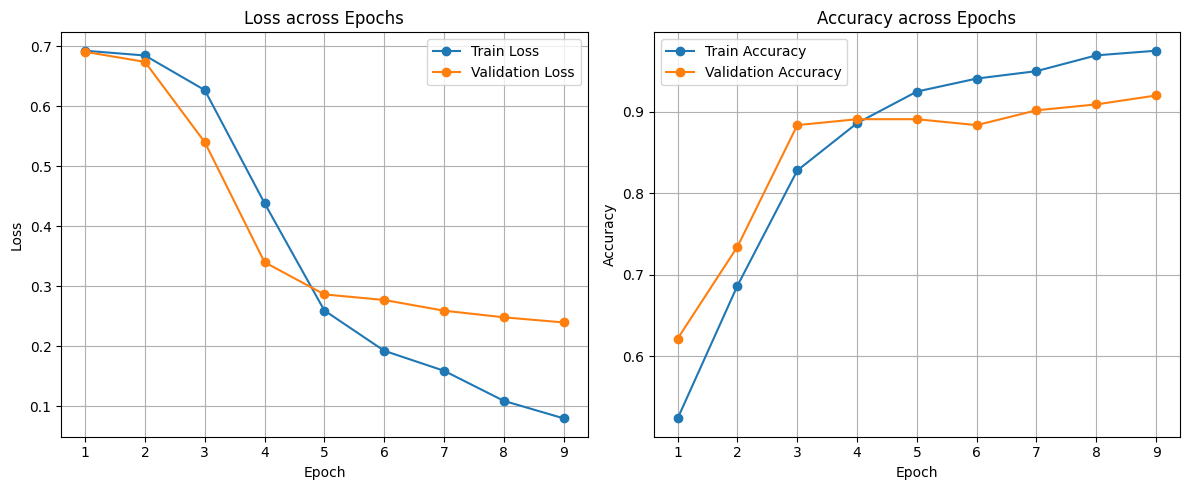

Test Loss: 0.2526, Accuracy: 0.9091, F1: 0.9093, Precision: 0.91, Recall: 0.9091, ROC AUC: 0.91, AUPR: 0.8963
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1379, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1373, 7)

#############################
Currently running solubility.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.41 Seconds
Train Loss: 0.6925, Accuracy: 0.5182, F1: 0.6827, Precision: 0.5182, Recall: 0.5182, ROC AUC: 0.5, AUPR: 0.5182
Val Loss: 0.6932, Accuracy: 0.4836, F1: 0.652, Precision: 0.4836, Recall: 0.4836, ROC AUC: 0.5, AUPR: 0.4836
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.55 Seconds
Train Loss: 0.6874, Accuracy: 0.5194, F1: 0.3563, Precision: 0.7506, Recall: 0.5194, ROC AUC: 0.5012, AUPR: 0.5188
Val Loss: 0.6784, Accuracy: 0.5491, F1: 0.446, Precision: 0.7667, Recall: 0.5491, ROC AUC: 0.5634, AUPR: 0.5175
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.56 Seconds
Train Loss: 0.6426, Accuracy: 0.7779, F1: 0.7727, Precision: 0.7973, Recall: 0.7779, ROC AUC: 0.7727, AUPR: 0.7094
Val Loss: 0.5579, Accuracy: 0.8909, F1: 0.8907, Preci

Test Loss: 0.4724, Accuracy: 0.9045, F1: 0.9038, Precision: 0.9096, Recall: 0.9045, ROC AUC: 0.9004, AUPR: 0.8577
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1379, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1373, 7)

#############################
Currently running solubility.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.43 Seconds
Train Loss: 0.6926, Accuracy: 0.5057, F1: 0.5009, Precision: 0.5046, Recall: 0.5057, ROC AUC: 0.5044, AUPR: 0.509
Val Loss: 0.6903, Accuracy: 0.5636, F1: 0.4632, Precision: 0.7137, Recall: 0.5636, ROC AUC: 0.5558, AUPR: 0.5386
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.51 Seconds
Train Loss: 0.6842, Accuracy: 0.6663, F1: 0.6504, Precision: 0.6985, Recall: 0.6663, ROC AUC: 0.6634, AUPR: 0.607
Val Loss: 0.6695, Accuracy: 0.7527, F1: 0.7527, Precision: 0.7528, Recall: 0.7527, ROC AUC: 0.7528, AUPR: 0.6979
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([878, 768])
Validation ...
	ET: 14.46 Seconds
Train Loss: 0.6063, Accuracy: 0.8121, F1: 0.8111, Precision: 0.8171, Recall: 0.8121, ROC AUC: 0.8112, AUPR: 0.7459
Val Loss: 0.5224, Accuracy: 0.8509, F1: 0.8509,

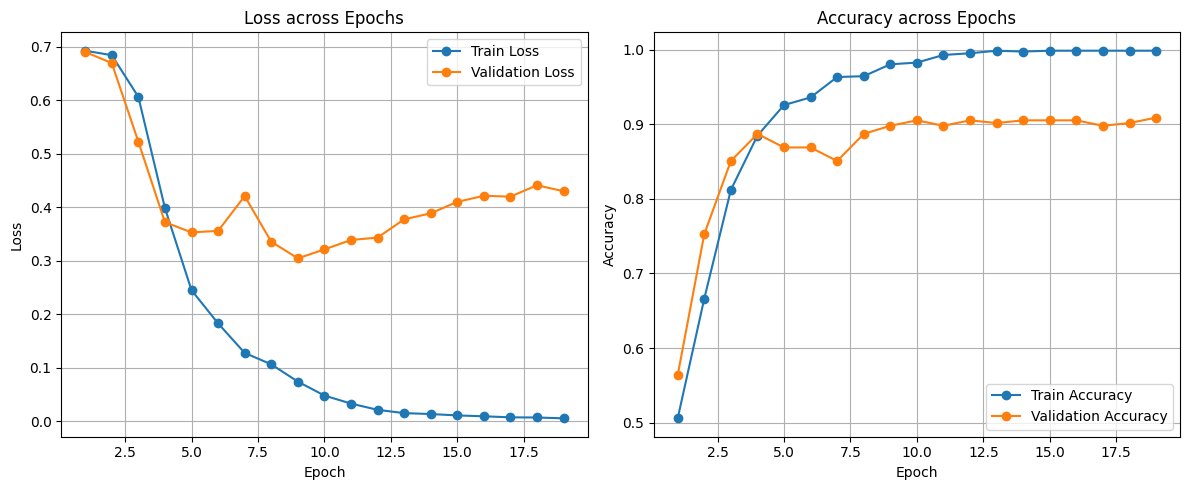

Test Loss: 0.3352, Accuracy: 0.9182, F1: 0.9179, Precision: 0.919, Recall: 0.9182, ROC AUC: 0.915, AUPR: 0.8868
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1379, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1373, 7)

#############################
Currently running solubility.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([879, 768])
Validation ...
	ET: 15.11 Seconds
Train Loss: 0.6929, Accuracy: 0.504, F1: 0.6702, Precision: 0.2549, Recall: 0.504, ROC AUC: 0.4989, AUPR: 0.5046
Val Loss: 0.6891, Accuracy: 0.5547, F1: 0.3998, Precision: 0.7537, Recall: 0.5547, ROC AUC: 0.5041, AUPR: 0.5531
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([879, 768])
Validation ...
	ET: 14.48 Seconds
Train Loss: 0.6846, Accuracy: 0.6655, F1: 0.6447, Precision: 0.7118, Recall: 0.6655, ROC AUC: 0.6631, AUPR: 0.6044
Val Loss: 0.6769, Accuracy: 0.6569, F1: 0.648, Precision: 0.7082, Recall: 0.6569, ROC AUC: 0.6759, AUPR: 0.6795
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([879, 768])
Validation ...
	ET: 14.51 Seconds
Train Loss: 0.6157, Accuracy: 0.81, F1: 0.81, Precision: 0.8102, Recall: 0.81, ROC AUC: 0.8099, AUPR: 0.7518
Val Loss: 0.5285, Accuracy: 0.8321, F1: 0.8315, Precis

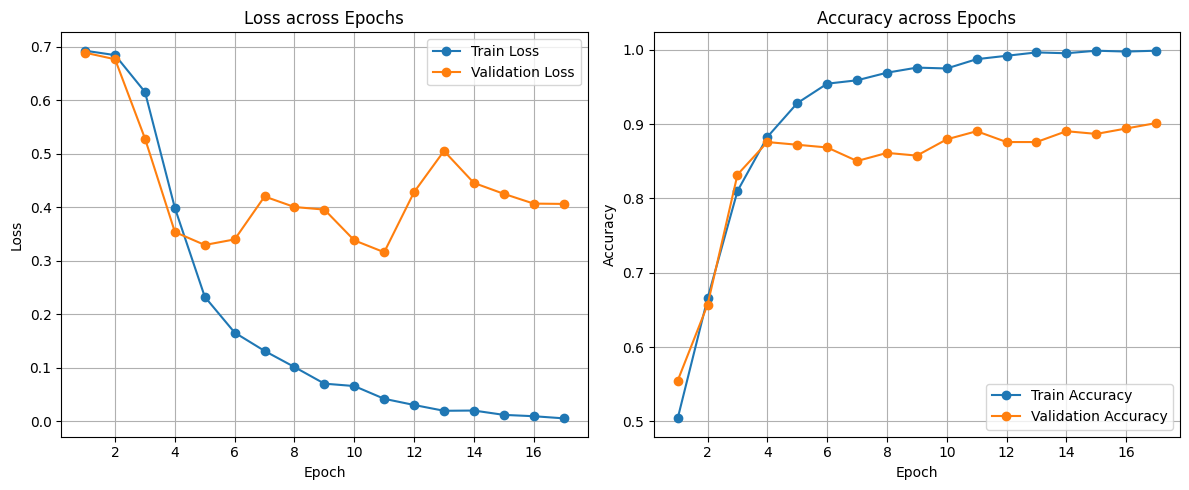

Test Loss: 0.3358, Accuracy: 0.9182, F1: 0.9181, Precision: 0.9194, Recall: 0.9182, ROC AUC: 0.9182, AUPR: 0.8749
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1379, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1373, 7)

#############################
Currently running solubility.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([879, 768])
Validation ...
	ET: 14.29 Seconds
Train Loss: 0.6926, Accuracy: 0.5381, F1: 0.4413, Precision: 0.5729, Recall: 0.5381, ROC AUC: 0.5236, AUPR: 0.5297
Val Loss: 0.6904, Accuracy: 0.5036, F1: 0.6699, Precision: 0.5036, Recall: 0.5036, ROC AUC: 0.5, AUPR: 0.5036
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([879, 768])
Validation ...
	ET: 14.38 Seconds
Train Loss: 0.6842, Accuracy: 0.6325, F1: 0.5738, Precision: 0.7565, Recall: 0.6325, ROC AUC: 0.6197, AUPR: 0.5853
Val Loss: 0.6704, Accuracy: 0.781, F1: 0.7795, Precision: 0.7882, Recall: 0.781, ROC AUC: 0.7804, AUPR: 0.7107
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([879, 768])
Validation ...
	ET: 14.47 Seconds
Train Loss: 0.6111, Accuracy: 0.8328, F1: 0.8325, Precision: 0.8335, Recall: 0.8328, ROC AUC: 0.8316, AUPR: 0.7802
Val Loss: 0.5092, Accuracy: 0.8723, F1: 0.8723, Pr

Test Loss: 0.4046, Accuracy: 0.8955, F1: 0.8954, Precision: 0.8957, Recall: 0.8955, ROC AUC: 0.8952, AUPR: 0.8532
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of DosageSensitivity labels: 2
Bert Variant: Pubmed_base


Gene name                                            Summary  \
0      ZSCAN9  Enables sequencespecific doublestranded DNA bi...   
1        SOX9  This region contains an enhancer that is thoug...   
2       ZC3H8  Enables RNA binding activity. Involved in seve...   
3        RXRG  This gene encodes a member of the retinoid X r...   
4        ZXDA  This gene encodes one of two duplicated zinc f...   
..        ...                                                ...   
275     FOXJ2  Enables DNAbinding transcription activator act...   
276      CARF  Enables DNA binding activity and DNAbinding tr...   
277    MTERF3  Enables transcription cisregulatory region bin...   
278     ZFHX4   May play a role in neural and muscle differen...   
279     MESP2  This gene encodes a member of the bHLH family ...   

     DosageSensitivity  Label  
0    DosageInsensitive      0  
1      DosageSensitive      1  
2    DosageInsensitive      0  
3      DosageSensitive      1  
4    DosageInsensitive      0  
..                 ...    ...  
275    DosageSensitive      1  
276  DosageInsensitive      0  
277  DosageInsensitive      0  
278    DosageSensitive      1  
279  DosageInsensitive      0  

[280 rows x 4 columns]

Shape of tokens_df before gene2vec:(280, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(277, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(280, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(277, 7)

#############################
Currently running DosageSensitivity.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([176, 768])
Validation ...
	ET: 3.08 Seconds
Train Loss: 0.6899, Accuracy: 0.6307, F1: 0.5928, Precision: 0.6271, Recall: 0.6307, ROC AUC: 0.5807, AUPR: 0.4731
Val Loss: 0.6874, Accuracy: 0.5714, F1: 0.7273, Precision: 0.5714, Recall: 0.5714, ROC AUC: 0.5, AUPR: 0.4286
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([176, 768])
Validation ...
	ET: 3.02 Seconds
Train Loss: 0.6839, Accuracy: 0.5852, F1: 0.7384, Precision: 0.5852, Recall: 0.5852, ROC AUC: 0.5, AUPR: 0.4148
Val Loss: 0.6825, Accuracy: 0.5714, F1: 0.7273, Precision: 0.5714, Recall: 0.5714, ROC AUC: 0.5, AUPR: 0.4286
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([176, 768])
Validation ...
	ET: 2.98 Seconds
Train Loss: 0.6779, Accuracy: 0.5909, F1: 0.4449, Precision: 0.7592, Recall: 0.5909, ROC AUC: 0.5068, AUPR: 0.4228
Val Loss: 0.6764, Accuracy: 0.5714, F1: 0.7273, Precision

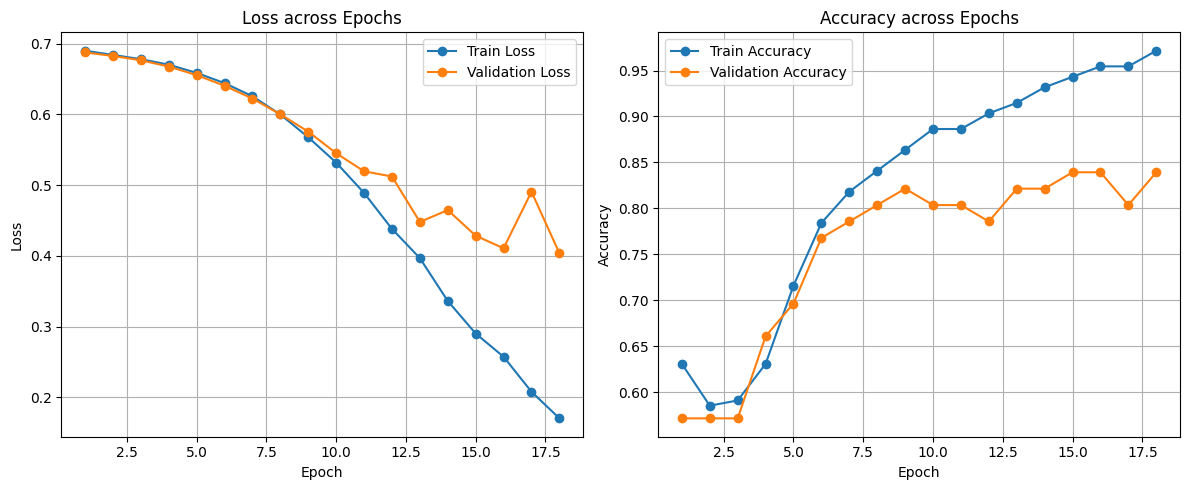

Test Loss: 0.6688, Accuracy: 0.7333, F1: 0.7556, Precision: 0.8467, Recall: 0.7333, ROC AUC: 0.7929, AUPR: 0.4272
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(280, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(277, 7)

#############################
Currently running DosageSensitivity.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([176, 768])
Validation ...
	ET: 3.06 Seconds
Train Loss: 0.6897, Accuracy: 0.5795, F1: 0.7338, Precision: 0.5795, Recall: 0.5795, ROC AUC: 0.5, AUPR: 0.4205
Val Loss: 0.6822, Accuracy: 0.625, F1: 0.7692, Precision: 0.625, Recall: 0.625, ROC AUC: 0.5, AUPR: 0.375
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([176, 768])
Validation ...
	ET: 3.05 Seconds
Train Loss: 0.685, Accuracy: 0.5795, F1: 0.7338, Precision: 0.5795, Recall: 0.5795, ROC AUC: 0.5, AUPR: 0.4205
Val Loss: 0.6769, Accuracy: 0.625, F1: 0.7692, Precision: 0.625, Recall: 0.625, ROC AUC: 0.5, AUPR: 0.375
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([176, 768])
Validation ...
	ET: 3.05 Seconds
Train Loss: 0.6804, Accuracy: 0.5795, F1: 0.7338, Precision: 0.5795, Recall: 0.5795, ROC AUC: 0.5, AUPR: 0.4205
Val Loss: 0.6711, Accuracy: 0.625, F1: 0.7692, Precision: 0.625, Recall:

Test Loss: 0.5689, Accuracy: 0.8889, F1: 0.8873, Precision: 0.8868, Recall: 0.8889, ROC AUC: 0.8447, AUPR: 0.6803
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(280, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(277, 7)

#############################
Currently running DosageSensitivity.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.09 Seconds
Train Loss: 0.6879, Accuracy: 0.6328, F1: 0.7751, Precision: 0.6328, Recall: 0.6328, ROC AUC: 0.5, AUPR: 0.3672
Val Loss: 0.688, Accuracy: 0.5455, F1: 0.7059, Precision: 0.5455, Recall: 0.5455, ROC AUC: 0.5, AUPR: 0.4545
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.02 Seconds
Train Loss: 0.6806, Accuracy: 0.6328, F1: 0.7751, Precision: 0.6328, Recall: 0.6328, ROC AUC: 0.5, AUPR: 0.3672
Val Loss: 0.6838, Accuracy: 0.5455, F1: 0.7059, Precision: 0.5455, Recall: 0.5455, ROC AUC: 0.5, AUPR: 0.4545
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.04 Seconds
Train Loss: 0.6733, Accuracy: 0.6328, F1: 0.7751, Precision: 0.6328, Recall: 0.6328, ROC AUC: 0.5, AUPR: 0.3672
Val Loss: 0.6786, Accuracy: 0.5455, F1: 0.7059, Precision: 0.545

Test Loss: 0.2556, Accuracy: 0.8444, F1: 0.8409, Precision: 0.8457, Recall: 0.8444, ROC AUC: 0.8172, AUPR: 0.7162
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(280, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(277, 7)

#############################
Currently running DosageSensitivity.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.06 Seconds
Train Loss: 0.692, Accuracy: 0.5593, F1: 0.4983, Precision: 0.5039, Recall: 0.5593, ROC AUC: 0.4902, AUPR: 0.3968
Val Loss: 0.6884, Accuracy: 0.6182, F1: 0.764, Precision: 0.6182, Recall: 0.6182, ROC AUC: 0.5, AUPR: 0.3818
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.03 Seconds
Train Loss: 0.6869, Accuracy: 0.5989, F1: 0.7491, Precision: 0.5989, Recall: 0.5989, ROC AUC: 0.5, AUPR: 0.4011
Val Loss: 0.6834, Accuracy: 0.6182, F1: 0.764, Precision: 0.6182, Recall: 0.6182, ROC AUC: 0.5, AUPR: 0.3818
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.17 Seconds
Train Loss: 0.6821, Accuracy: 0.5989, F1: 0.7491, Precision: 0.5989, Recall: 0.5989, ROC AUC: 0.5, AUPR: 0.4011
Val Loss: 0.678, Accuracy: 0.6182, F1: 0.764, Precision: 0.6182

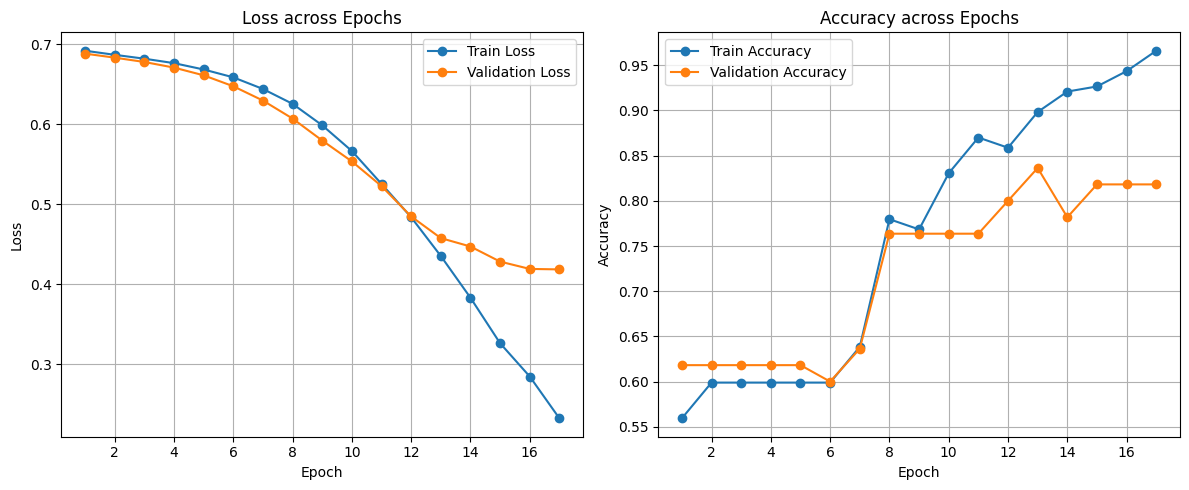

Test Loss: 0.3305, Accuracy: 0.8444, F1: 0.8456, Precision: 0.8477, Recall: 0.8444, ROC AUC: 0.8333, AUPR: 0.6667
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(280, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(277, 7)

#############################
Currently running DosageSensitivity.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 2.99 Seconds
Train Loss: 0.6949, Accuracy: 0.4237, F1: 0.5952, Precision: 0.4237, Recall: 0.4237, ROC AUC: 0.5, AUPR: 0.4237
Val Loss: 0.693, Accuracy: 0.4909, F1: 0.4672, Precision: 0.8149, Recall: 0.4909, ROC AUC: 0.641, AUPR: 0.3636
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 3.02 Seconds
Train Loss: 0.6896, Accuracy: 0.7627, F1: 0.7641, Precision: 0.775, Recall: 0.7627, ROC AUC: 0.7694, AUPR: 0.6365
Val Loss: 0.6856, Accuracy: 0.7636, F1: 0.7657, Precision: 0.7683, Recall: 0.7636, ROC AUC: 0.7228, AUPR: 0.4767
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([177, 768])
Validation ...
	ET: 2.96 Seconds
Train Loss: 0.6843, Accuracy: 0.7458, F1: 0.7311, Precision: 0.7635, Recall: 0.7458, ROC AUC: 0.7141, AUPR: 0.6276
Val Loss: 0.6787, Accuracy: 0.7636, F1: 0.7558, Precis

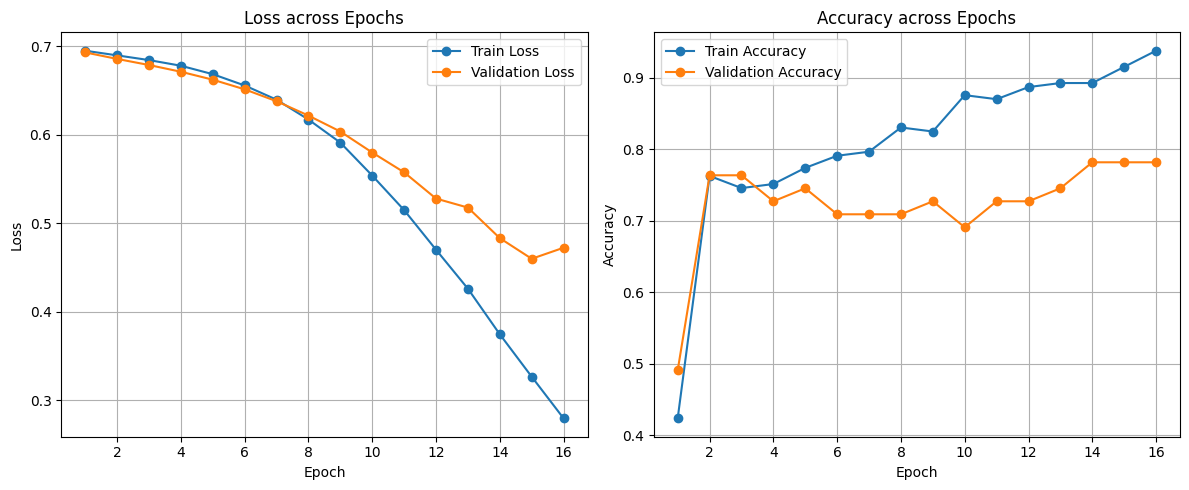

Test Loss: 0.2841, Accuracy: 0.9111, F1: 0.9121, Precision: 0.9169, Recall: 0.9111, ROC AUC: 0.917, AUPR: 0.8035
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of BivalentVsLys4 labels: 2
Bert Variant: Pubmed_base


Gene name                                            Summary  \
0        MYNN  This gene encodes a member of the BTB/POZ and ...   
1      COMTD1  Predicted to enable Sadenosylmethioninedepende...   
2        IRX3  IRX3 is a member of the Iroquois homeobox gene...   
3     KAZALD1  This gene encodes a secreted member of the ins...   
4      ARRDC4  Predicted to enable ubiquitin ligasesubstrate ...   
..        ...                                                ...   
142     HOXD8  This gene belongs to the homeobox family of ge...   
143    IMMP1L  The mitochondrial inner membrane peptidase (IM...   
144     FOXD3   Binds to the consensus sequence 5'A[AT]T[AG]T...   
145     HOXD3  This gene belongs to the homeobox family of ge...   
146      IRX1  This gene encodes a member of the Iroquois hom...   

    BivalentVsLys4  Label  
0         Lys4Only      0  
1         Lys4Only      0  
2         Bivalent      1  
3         Bivalent      1  
4         Lys4Only      0  
..             ...    ...  
142       Bivalent      1  
143       Lys4Only      0  
144       Bivalent      1  
145       Bivalent      1  
146       Bivalent      1  

[147 rows x 4 columns]

Shape of tokens_df before gene2vec:(147, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(146, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(147, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(146, 7)

#############################
Currently running BivalentVsLys4.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([92, 768])
Validation ...
	ET: 1.71 Seconds
Train Loss: 0.6896, Accuracy: 0.5652, F1: 0.7222, Precision: 0.5652, Recall: 0.5652, ROC AUC: 0.5, AUPR: 0.5652
Val Loss: 0.6894, Accuracy: 0.5667, F1: 0.7234, Precision: 0.5667, Recall: 0.5667, ROC AUC: 0.5, AUPR: 0.5667
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([92, 768])
Validation ...
	ET: 1.69 Seconds
Train Loss: 0.6874, Accuracy: 0.5652, F1: 0.7222, Precision: 0.5652, Recall: 0.5652, ROC AUC: 0.5, AUPR: 0.5652
Val Loss: 0.6876, Accuracy: 0.5667, F1: 0.7234, Precision: 0.5667, Recall: 0.5667, ROC AUC: 0.5, AUPR: 0.5667
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([92, 768])
Validation ...
	ET: 1.69 Seconds
Train Loss: 0.6858, Accuracy: 0.5652, F1: 0.7222, Precision: 0.5652, Recall: 0.5652, ROC AUC: 0.5, AUPR: 0.5652
Val Loss: 0.6857, Accuracy: 0.5667, F1: 0.7234, Precision: 0.5667,

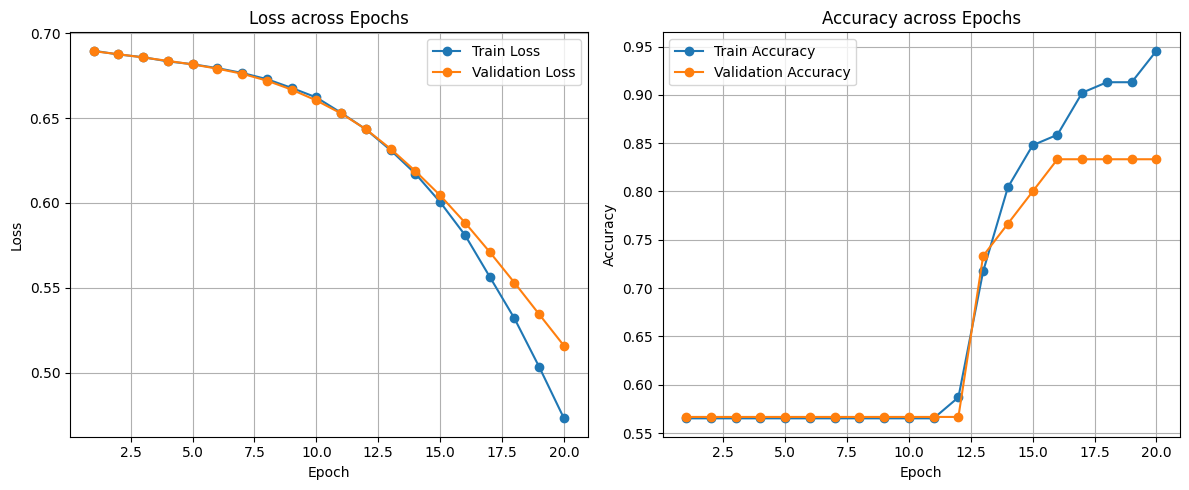

Test Loss: 0.4631, Accuracy: 0.7917, F1: 0.7822, Precision: 0.8529, Recall: 0.7917, ROC AUC: 0.7917, AUPR: 0.7059
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(147, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(146, 7)

#############################
Currently running BivalentVsLys4.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.69 Seconds
Train Loss: 0.6912, Accuracy: 0.5484, F1: 0.7083, Precision: 0.5484, Recall: 0.5484, ROC AUC: 0.5, AUPR: 0.5484
Val Loss: 0.69, Accuracy: 0.5862, F1: 0.7391, Precision: 0.5862, Recall: 0.5862, ROC AUC: 0.5, AUPR: 0.5862
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.69 Seconds
Train Loss: 0.6884, Accuracy: 0.5591, F1: 0.4122, Precision: 0.7556, Recall: 0.5591, ROC AUC: 0.5119, AUPR: 0.5543
Val Loss: 0.688, Accuracy: 0.5862, F1: 0.7391, Precision: 0.5862, Recall: 0.5862, ROC AUC: 0.5, AUPR: 0.5862
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.69 Seconds
Train Loss: 0.686, Accuracy: 0.5484, F1: 0.7083, Precision: 0.5484, Recall: 0.5484, ROC AUC: 0.5, AUPR: 0.5484
Val Loss: 0.6856, Accuracy: 0.5862, F1: 0.7391, Precision: 0.5862, 

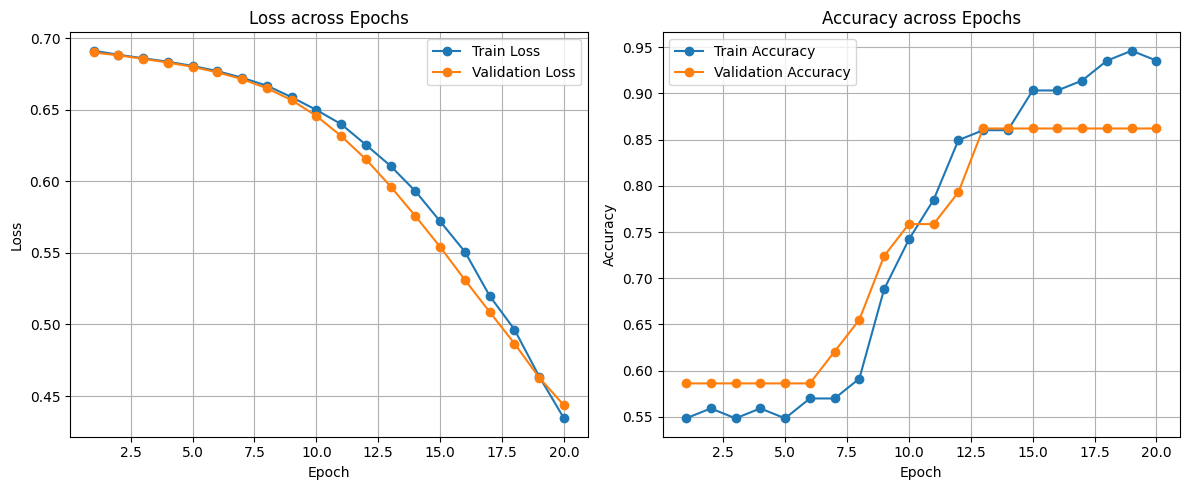

Test Loss: 0.466, Accuracy: 0.875, F1: 0.8716, Precision: 0.8984, Recall: 0.875, ROC AUC: 0.8636, AUPR: 0.8125
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(147, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(146, 7)

#############################
Currently running BivalentVsLys4.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.71 Seconds
Train Loss: 0.6949, Accuracy: 0.4731, F1: 0.6423, Precision: 0.4731, Recall: 0.4731, ROC AUC: 0.5, AUPR: 0.5269
Val Loss: 0.6939, Accuracy: 0.4483, F1: 0.619, Precision: 0.4483, Recall: 0.4483, ROC AUC: 0.5, AUPR: 0.5517
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.63 Seconds
Train Loss: 0.6932, Accuracy: 0.4731, F1: 0.6423, Precision: 0.4731, Recall: 0.4731, ROC AUC: 0.5, AUPR: 0.5269
Val Loss: 0.6924, Accuracy: 0.4483, F1: 0.619, Precision: 0.4483, Recall: 0.4483, ROC AUC: 0.5, AUPR: 0.5517
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.71 Seconds
Train Loss: 0.6916, Accuracy: 0.5054, F1: 0.3715, Precision: 0.7582, Recall: 0.5054, ROC AUC: 0.5306, AUPR: 0.5558
Val Loss: 0.6907, Accuracy: 0.6207, F1: 0.5777, Precision: 0.7945

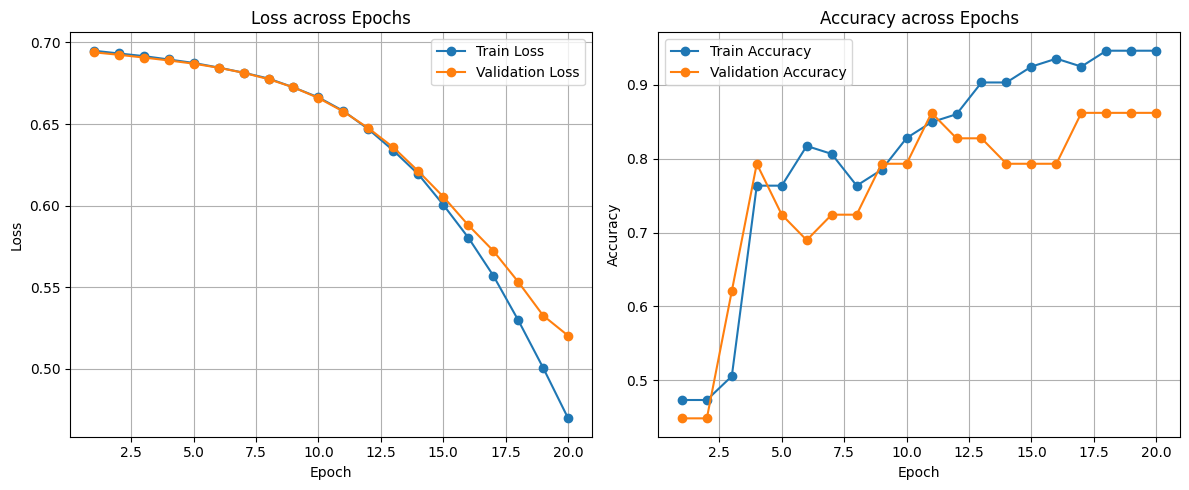

Test Loss: 0.5742, Accuracy: 0.7917, F1: 0.7944, Precision: 0.8, Recall: 0.7917, ROC AUC: 0.7812, AUPR: 0.8292
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(147, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(146, 7)

#############################
Currently running BivalentVsLys4.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.72 Seconds
Train Loss: 0.6951, Accuracy: 0.4409, F1: 0.6119, Precision: 0.4409, Recall: 0.4409, ROC AUC: 0.5, AUPR: 0.5591
Val Loss: 0.6933, Accuracy: 0.5517, F1: 0.7111, Precision: 0.5517, Recall: 0.5517, ROC AUC: 0.5, AUPR: 0.4483
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.69 Seconds
Train Loss: 0.6921, Accuracy: 0.4946, F1: 0.442, Precision: 0.5648, Recall: 0.4946, ROC AUC: 0.5326, AUPR: 0.5777
Val Loss: 0.6929, Accuracy: 0.5862, F1: 0.5842, Precision: 0.6051, Recall: 0.5862, ROC AUC: 0.5962, AUPR: 0.5044
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.63 Seconds
Train Loss: 0.6897, Accuracy: 0.7419, F1: 0.7211, Precision: 0.7872, Recall: 0.7419, ROC AUC: 0.7125, AUPR: 0.6892
Val Loss: 0.6927, Accuracy: 0.4828, F1: 0.392, Precision: 

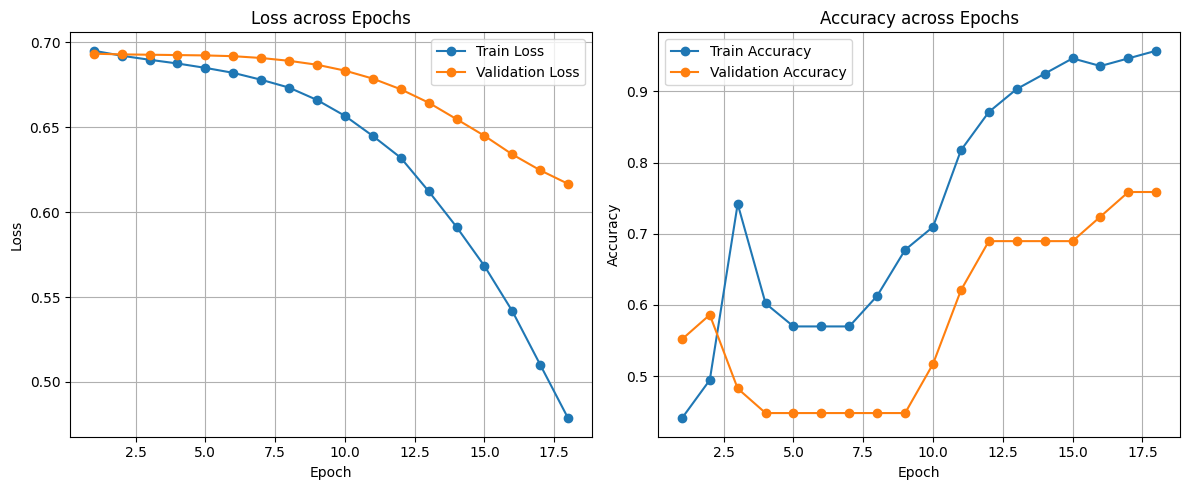

Test Loss: 0.512, Accuracy: 0.875, F1: 0.8727, Precision: 0.8739, Recall: 0.875, ROC AUC: 0.8438, AUPR: 0.8689
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(147, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(146, 7)

#############################
Currently running BivalentVsLys4.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.68 Seconds
Train Loss: 0.6894, Accuracy: 0.5484, F1: 0.7083, Precision: 0.5484, Recall: 0.5484, ROC AUC: 0.5, AUPR: 0.5484
Val Loss: 0.6821, Accuracy: 0.6207, F1: 0.766, Precision: 0.6207, Recall: 0.6207, ROC AUC: 0.5, AUPR: 0.6207
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.65 Seconds
Train Loss: 0.6871, Accuracy: 0.5484, F1: 0.7083, Precision: 0.5484, Recall: 0.5484, ROC AUC: 0.5, AUPR: 0.5484
Val Loss: 0.6792, Accuracy: 0.6207, F1: 0.766, Precision: 0.6207, Recall: 0.6207, ROC AUC: 0.5, AUPR: 0.6207
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([93, 768])
Validation ...
	ET: 1.64 Seconds
Train Loss: 0.685, Accuracy: 0.5484, F1: 0.7083, Precision: 0.5484, Recall: 0.5484, ROC AUC: 0.5, AUPR: 0.5484
Val Loss: 0.6761, Accuracy: 0.6207, F1: 0.766, Precision: 0.6207, Rec

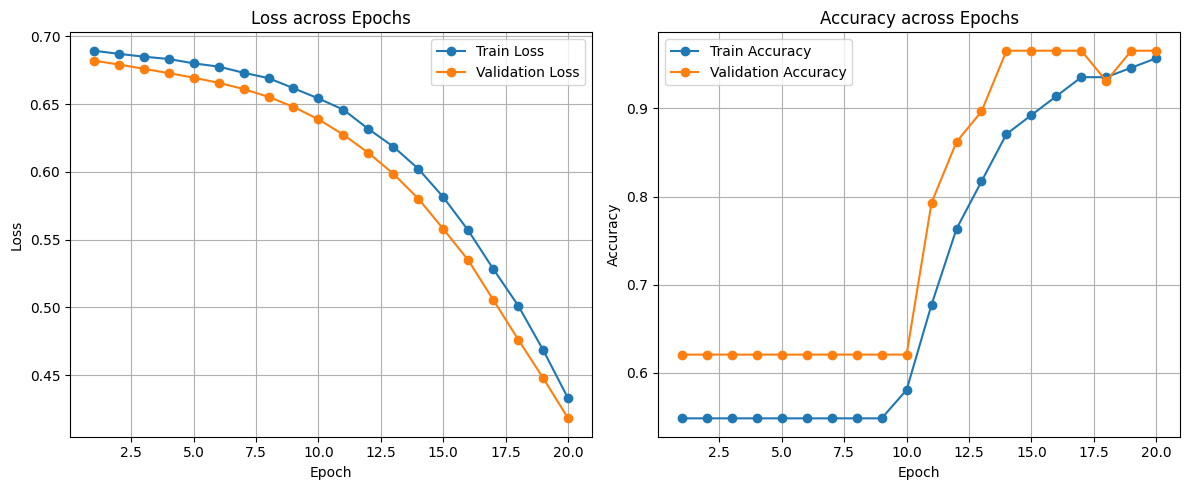

Test Loss: 0.4422, Accuracy: 0.8333, F1: 0.8322, Precision: 0.8429, Recall: 0.8333, ROC AUC: 0.8333, AUPR: 0.7619
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of BivalentVsNonMethylated labels: 2
Bert Variant: Pubmed_base


Gene name                                            Summary  \
0        IRX3  IRX3 is a member of the Iroquois homeobox gene...   
1     KAZALD1  This gene encodes a secreted member of the ins...   
2     HSD17B1  This region represents the promoter of the hyd...   
3       PITX3  This gene encodes a member of the RIEG/PITX ho...   
4       HOXB8  This gene is a member of the Antp homeobox fam...   
..        ...                                                ...   
105     HOXD8  This gene belongs to the homeobox family of ge...   
106    INPP5A  The protein encoded by this gene is a membrane...   
107     FOXD3   Binds to the consensus sequence 5'A[AT]T[AG]T...   
108     HOXD3  This gene belongs to the homeobox family of ge...   
109      IRX1  This gene encodes a member of the Iroquois hom...   

    BivalentVsNonMethylated  Label  
0                  Bivalent      0  
1                  Bivalent      0  
2                  Bivalent      0  
3                  Bivalent      0  
4                  Bivalent      0  
..                      ...    ...  
105                Bivalent      0  
106           NonMethylated      1  
107                Bivalent      0  
108                Bivalent      0  
109                Bivalent      0  

[110 rows x 4 columns]

Shape of tokens_df before gene2vec:(110, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(110, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(110, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(110, 7)

#############################
Currently running BivalentVsNonMethylated.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.48 Seconds
Train Loss: 0.6962, Accuracy: 0.3, F1: 0.1899, Precision: 0.8119, Recall: 0.3, ROC AUC: 0.5288, AUPR: 0.2687
Val Loss: 0.6917, Accuracy: 0.7273, F1: 0.7169, Precision: 0.7197, Recall: 0.7273, ROC AUC: 0.6786, AUPR: 0.5152
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.37 Seconds
Train Loss: 0.6866, Accuracy: 0.7857, F1: 0.7585, Precision: 0.7681, Recall: 0.7857, ROC AUC: 0.6378, AUPR: 0.3937
Val Loss: 0.6886, Accuracy: 0.6364, F1: 0.7778, Precision: 0.6364, Recall: 0.6364, ROC AUC: 0.5, AUPR: 0.3636
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.32 Seconds
Train Loss: 0.6771, Accuracy: 0.7429, F1: 0.8525, Precision: 0.7429, Recall: 0.7429, ROC AUC: 0.5, AUPR: 0.2571
Val Loss: 0.6862, Accuracy: 0.6364, F1: 0.7778, Precision: 0.6364, Recall: 0.6364

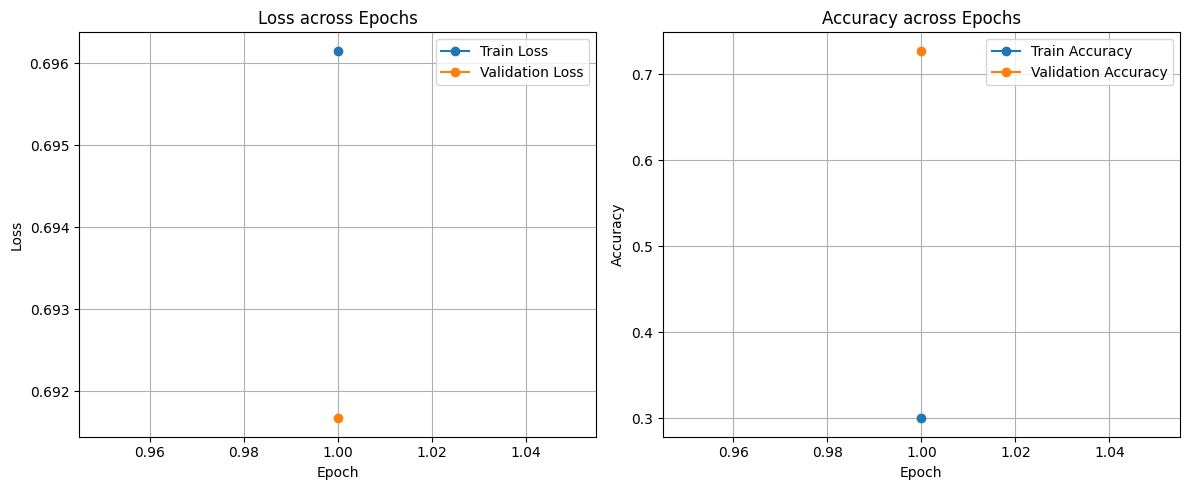

Test Loss: 0.6916, Accuracy: 0.7222, F1: 0.7325, Precision: 0.747, Recall: 0.7222, ROC AUC: 0.6429, AUPR: 0.3111
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(110, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(110, 7)

#############################
Currently running BivalentVsNonMethylated.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.45 Seconds
Train Loss: 0.6859, Accuracy: 0.7571, F1: 0.8618, Precision: 0.7571, Recall: 0.7571, ROC AUC: 0.5, AUPR: 0.2429
Val Loss: 0.689, Accuracy: 0.5909, F1: 0.7429, Precision: 0.5909, Recall: 0.5909, ROC AUC: 0.5, AUPR: 0.4091
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.3 Seconds
Train Loss: 0.6767, Accuracy: 0.7571, F1: 0.8618, Precision: 0.7571, Recall: 0.7571, ROC AUC: 0.5, AUPR: 0.2429
Val Loss: 0.6865, Accuracy: 0.5909, F1: 0.7429, Precision: 0.5909, Recall: 0.5909, ROC AUC: 0.5, AUPR: 0.4091
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.34 Seconds
Train Loss: 0.6677, Accuracy: 0.7571, F1: 0.8618, Precision: 0.7571, Recall: 0.7571, ROC AUC: 0.5, AUPR: 0.2429
Val Loss: 0.6843, Accuracy: 0.5909, F1: 0.7429, Precision: 0.5909, R

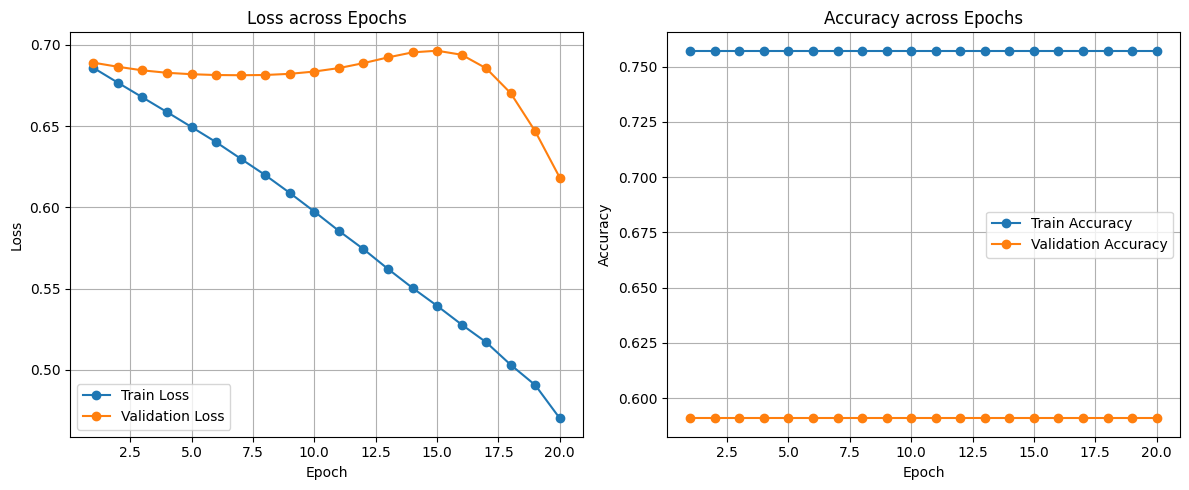

Test Loss: 0.4459, Accuracy: 0.7778, F1: 0.875, Precision: 0.7778, Recall: 0.7778, ROC AUC: 0.5, AUPR: 0.2222
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(110, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(110, 7)

#############################
Currently running BivalentVsNonMethylated.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.47 Seconds
Train Loss: 0.6856, Accuracy: 0.7, F1: 0.8235, Precision: 0.7, Recall: 0.7, ROC AUC: 0.5, AUPR: 0.3
Val Loss: 0.672, Accuracy: 0.8636, F1: 0.9268, Precision: 0.8636, Recall: 0.8636, ROC AUC: 0.5, AUPR: 0.1364
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.3 Seconds
Train Loss: 0.6775, Accuracy: 0.7, F1: 0.8235, Precision: 0.7, Recall: 0.7, ROC AUC: 0.5, AUPR: 0.3
Val Loss: 0.6591, Accuracy: 0.8636, F1: 0.9268, Precision: 0.8636, Recall: 0.8636, ROC AUC: 0.5, AUPR: 0.1364
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.33 Seconds
Train Loss: 0.6702, Accuracy: 0.7, F1: 0.8235, Precision: 0.7, Recall: 0.7, ROC AUC: 0.5, AUPR: 0.3
Val Loss: 0.6467, Accuracy: 0.8636, F1: 0.9268, Precision: 0.8636, Recall: 0.8636, ROC AUC: 0.5, AUPR: 0

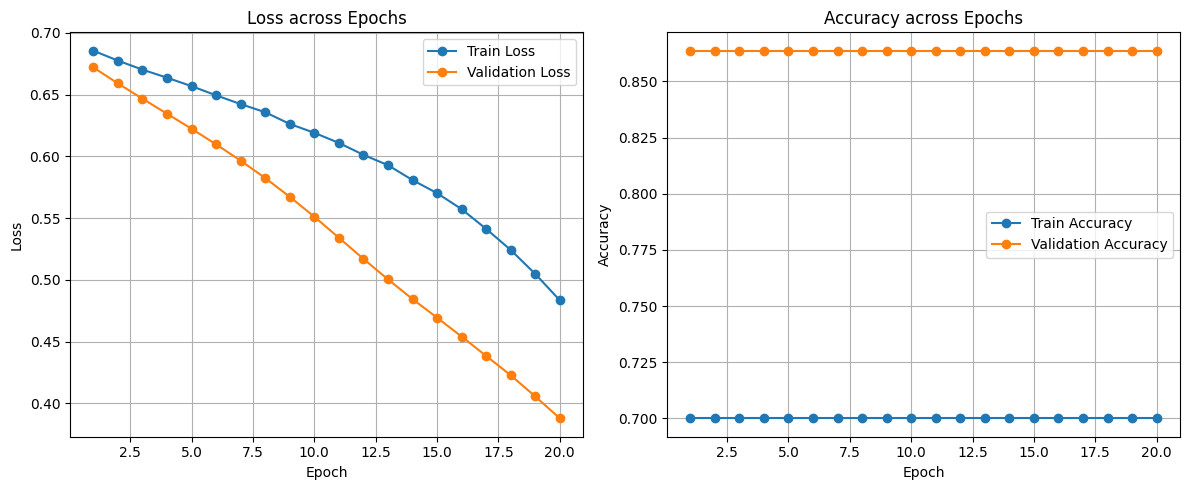

Test Loss: 0.5532, Accuracy: 0.6667, F1: 0.8, Precision: 0.6667, Recall: 0.6667, ROC AUC: 0.5, AUPR: 0.3333
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(110, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(110, 7)

#############################
Currently running BivalentVsNonMethylated.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.36 Seconds
Train Loss: 0.6989, Accuracy: 0.3, F1: 0.4615, Precision: 0.3, Recall: 0.3, ROC AUC: 0.5, AUPR: 0.3
Val Loss: 0.6948, Accuracy: 0.1818, F1: 0.3077, Precision: 0.1818, Recall: 0.1818, ROC AUC: 0.5, AUPR: 0.1818
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.29 Seconds
Train Loss: 0.6922, Accuracy: 0.5286, F1: 0.548, Precision: 0.6147, Recall: 0.5286, ROC AUC: 0.5408, AUPR: 0.319
Val Loss: 0.6887, Accuracy: 0.8182, F1: 0.9, Precision: 0.8182, Recall: 0.8182, ROC AUC: 0.5, AUPR: 0.1818
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.31 Seconds
Train Loss: 0.6846, Accuracy: 0.7, F1: 0.8235, Precision: 0.7, Recall: 0.7, ROC AUC: 0.5, AUPR: 0.3
Val Loss: 0.6824, Accuracy: 0.8182, F1: 0.9, Precision: 0.8182, Recall: 0.8182, ROC AUC: 0.5

Test Loss: 0.5051, Accuracy: 0.7222, F1: 0.8387, Precision: 0.7222, Recall: 0.7222, ROC AUC: 0.5, AUPR: 0.2778
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(110, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(110, 7)

#############################
Currently running BivalentVsNonMethylated.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.79 Seconds
Train Loss: 0.6755, Accuracy: 0.7286, F1: 0.843, Precision: 0.7286, Recall: 0.7286, ROC AUC: 0.5, AUPR: 0.2714
Val Loss: 0.6583, Accuracy: 0.7273, F1: 0.8421, Precision: 0.7273, Recall: 0.7273, ROC AUC: 0.5, AUPR: 0.2727
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.35 Seconds
Train Loss: 0.6685, Accuracy: 0.7286, F1: 0.843, Precision: 0.7286, Recall: 0.7286, ROC AUC: 0.5, AUPR: 0.2714
Val Loss: 0.649, Accuracy: 0.7273, F1: 0.8421, Precision: 0.7273, Recall: 0.7273, ROC AUC: 0.5, AUPR: 0.2727
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([70, 768])
Validation ...
	ET: 1.29 Seconds
Train Loss: 0.6615, Accuracy: 0.7286, F1: 0.843, Precision: 0.7286, Recall: 0.7286, ROC AUC: 0.5, AUPR: 0.2714
Val Loss: 0.6396, Accuracy: 0.7273, F1: 0.8421, Precision: 0.7273, Rec

Test Loss: 0.5273, Accuracy: 0.7222, F1: 0.8387, Precision: 0.7222, Recall: 0.7222, ROC AUC: 0.5, AUPR: 0.2778
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of Tf_range labels: 2
Bert Variant: Pubmed_base


Gene name                                            Summary     Tf_range  \
0       GATA4  This gene encodes a member of the GATA family ...  Short_range   
1        SOX9  This region contains an enhancer that is thoug...   Long_range   
2       HOXC9  This gene belongs to the homeobox family of ge...   Long_range   
3        TCF3  This gene encodes a member of the E protein (c...  Short_range   
4       SOX15  This gene encodes a member of the SOX (SRYrela...   Long_range   
..        ...                                                ...          ...   
151     DMRT1  This gene is found in a cluster with two other...  Short_range   
152      RBPJ  The protein encoded by this gene is a transcri...  Short_range   
153      EGR2  The protein encoded by this gene is a transcri...  Short_range   
154       PGR  This gene encodes a member of the steroid rece...  Short_range   
155     TBX20  This gene encodes a Tbox family member. The Tb...  Short_range   

     Label  
0        0  
1        1  
2        1  
3        0  
4        1  
..     ...  
151      0  
152      0  
153      0  
154      0  
155      0  

[156 rows x 4 columns]

Shape of tokens_df before gene2vec:(156, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(156, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(156, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(156, 7)

#############################
Currently running Tf_range.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([99, 768])
Validation ...
	ET: 1.76 Seconds
Train Loss: 0.6949, Accuracy: 0.3535, F1: 0.3512, Precision: 0.4567, Recall: 0.3535, ROC AUC: 0.4081, AUPR: 0.2903
Val Loss: 0.6885, Accuracy: 0.7812, F1: 0.8772, Precision: 0.7812, Recall: 0.7812, ROC AUC: 0.5, AUPR: 0.2188
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([99, 768])
Validation ...
	ET: 1.79 Seconds
Train Loss: 0.6884, Accuracy: 0.6768, F1: 0.8072, Precision: 0.6768, Recall: 0.6768, ROC AUC: 0.5, AUPR: 0.3232
Val Loss: 0.6791, Accuracy: 0.7812, F1: 0.8772, Precision: 0.7812, Recall: 0.7812, ROC AUC: 0.5, AUPR: 0.2188
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([99, 768])
Validation ...
	ET: 1.88 Seconds
Train Loss: 0.6827, Accuracy: 0.6768, F1: 0.8072, Precision: 0.6768, Recall: 0.6768, ROC AUC: 0.5, AUPR: 0.3232
Val Loss: 0.6705, Accuracy: 0.7812, F1: 0.8772, Precision: 0.78

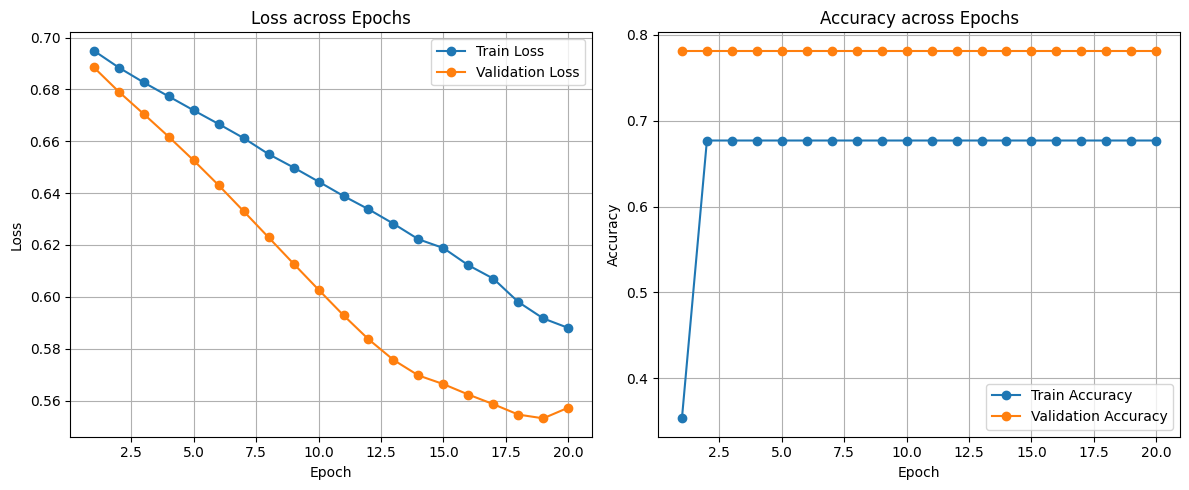

Test Loss: 0.4701, Accuracy: 0.88, F1: 0.9362, Precision: 0.88, Recall: 0.88, ROC AUC: 0.5, AUPR: 0.12
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(156, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(156, 7)

#############################
Currently running Tf_range.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.74 Seconds
Train Loss: 0.6876, Accuracy: 0.76, F1: 0.7007, Precision: 0.7102, Recall: 0.76, ROC AUC: 0.5428, AUPR: 0.2725
Val Loss: 0.6883, Accuracy: 0.6452, F1: 0.7843, Precision: 0.6452, Recall: 0.6452, ROC AUC: 0.5, AUPR: 0.3548
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.76 Seconds
Train Loss: 0.6771, Accuracy: 0.76, F1: 0.8636, Precision: 0.76, Recall: 0.76, ROC AUC: 0.5, AUPR: 0.24
Val Loss: 0.6852, Accuracy: 0.6452, F1: 0.7843, Precision: 0.6452, Recall: 0.6452, ROC AUC: 0.5, AUPR: 0.3548
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.72 Seconds
Train Loss: 0.6671, Accuracy: 0.76, F1: 0.8636, Precision: 0.76, Recall: 0.76, ROC AUC: 0.5, AUPR: 0.24
Val Loss: 0.6823, Accuracy: 0.6452, F1: 0.7843, Precision: 0.6452, Recall: 0.645

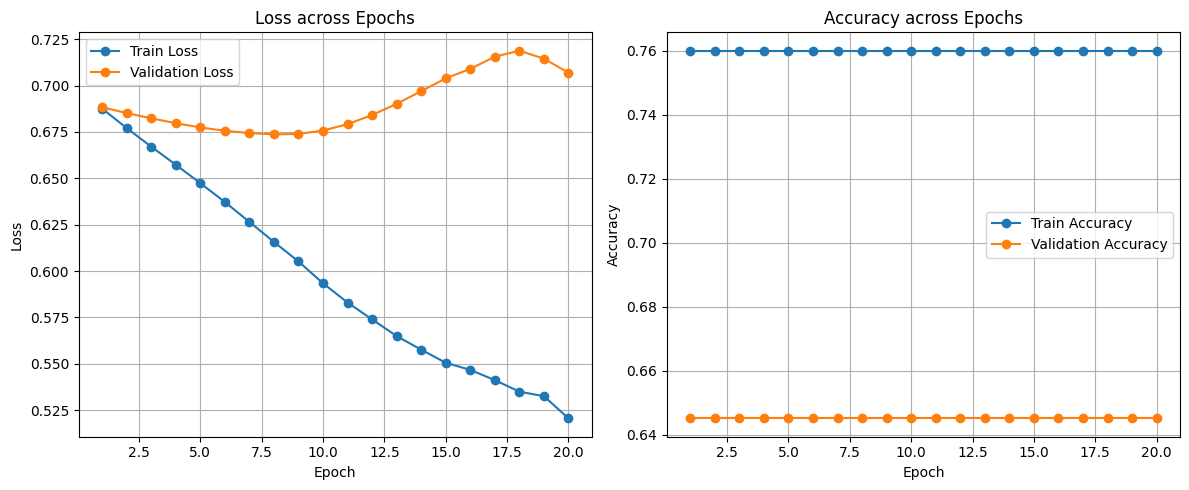

Test Loss: 0.566, Accuracy: 0.72, F1: 0.8372, Precision: 0.72, Recall: 0.72, ROC AUC: 0.5, AUPR: 0.28
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(156, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(156, 7)

#############################
Currently running Tf_range.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.74 Seconds
Train Loss: 0.6933, Accuracy: 0.45, F1: 0.5005, Precision: 0.6182, Recall: 0.45, ROC AUC: 0.4247, AUPR: 0.191
Val Loss: 0.6899, Accuracy: 0.6129, F1: 0.76, Precision: 0.6129, Recall: 0.6129, ROC AUC: 0.5, AUPR: 0.3871
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.76 Seconds
Train Loss: 0.6782, Accuracy: 0.79, F1: 0.8827, Precision: 0.79, Recall: 0.79, ROC AUC: 0.5, AUPR: 0.21
Val Loss: 0.6828, Accuracy: 0.6129, F1: 0.76, Precision: 0.6129, Recall: 0.6129, ROC AUC: 0.5, AUPR: 0.3871
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.89 Seconds
Train Loss: 0.6647, Accuracy: 0.79, F1: 0.8827, Precision: 0.79, Recall: 0.79, ROC AUC: 0.5, AUPR: 0.21
Val Loss: 0.6776, Accuracy: 0.6129, F1: 0.76, Precision: 0.6129, Recall: 0.6129, ROC 

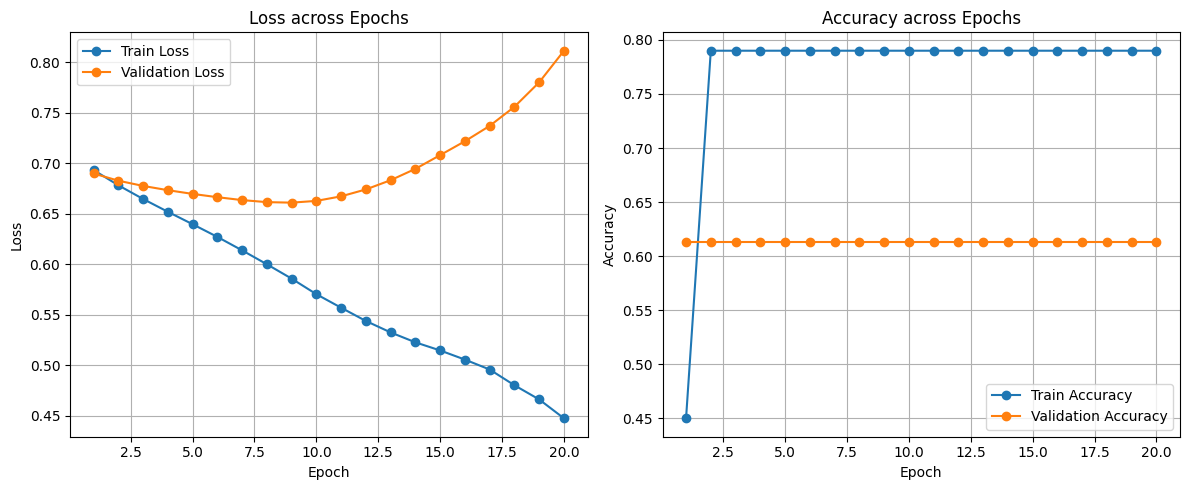

Test Loss: 0.7002, Accuracy: 0.64, F1: 0.7805, Precision: 0.64, Recall: 0.64, ROC AUC: 0.5, AUPR: 0.36
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(156, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(156, 7)

#############################
Currently running Tf_range.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.72 Seconds
Train Loss: 0.6865, Accuracy: 0.69, F1: 0.8166, Precision: 0.69, Recall: 0.69, ROC AUC: 0.5, AUPR: 0.31
Val Loss: 0.6835, Accuracy: 0.7097, F1: 0.8302, Precision: 0.7097, Recall: 0.7097, ROC AUC: 0.5, AUPR: 0.2903
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.77 Seconds
Train Loss: 0.6816, Accuracy: 0.69, F1: 0.8166, Precision: 0.69, Recall: 0.69, ROC AUC: 0.5, AUPR: 0.31
Val Loss: 0.679, Accuracy: 0.7097, F1: 0.8302, Precision: 0.7097, Recall: 0.7097, ROC AUC: 0.5, AUPR: 0.2903
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.74 Seconds
Train Loss: 0.677, Accuracy: 0.69, F1: 0.8166, Precision: 0.69, Recall: 0.69, ROC AUC: 0.5, AUPR: 0.31
Val Loss: 0.6747, Accuracy: 0.7097, F1: 0.8302, Precision: 0.7097, Recall: 0.7097, ROC AU

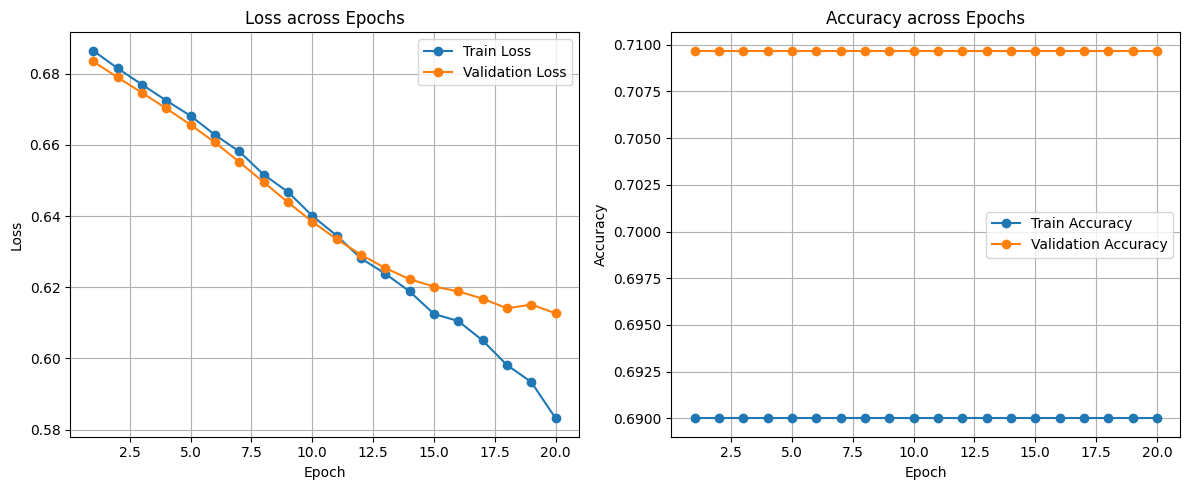

Test Loss: 0.4409, Accuracy: 0.92, F1: 0.9583, Precision: 0.92, Recall: 0.92, ROC AUC: 0.5, AUPR: 0.08
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(156, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(156, 7)

#############################
Currently running Tf_range.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.83 Seconds
Train Loss: 0.6866, Accuracy: 0.67, F1: 0.8024, Precision: 0.67, Recall: 0.67, ROC AUC: 0.5, AUPR: 0.33
Val Loss: 0.6692, Accuracy: 0.9032, F1: 0.9492, Precision: 0.9032, Recall: 0.9032, ROC AUC: 0.5, AUPR: 0.0968
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.7 Seconds
Train Loss: 0.681, Accuracy: 0.67, F1: 0.8024, Precision: 0.67, Recall: 0.67, ROC AUC: 0.5, AUPR: 0.33
Val Loss: 0.6564, Accuracy: 0.9032, F1: 0.9492, Precision: 0.9032, Recall: 0.9032, ROC AUC: 0.5, AUPR: 0.0968
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([100, 768])
Validation ...
	ET: 1.87 Seconds
Train Loss: 0.676, Accuracy: 0.67, F1: 0.8024, Precision: 0.67, Recall: 0.67, ROC AUC: 0.5, AUPR: 0.33
Val Loss: 0.6443, Accuracy: 0.9032, F1: 0.9492, Precision: 0.9032, Recall: 0.9032, ROC AUC

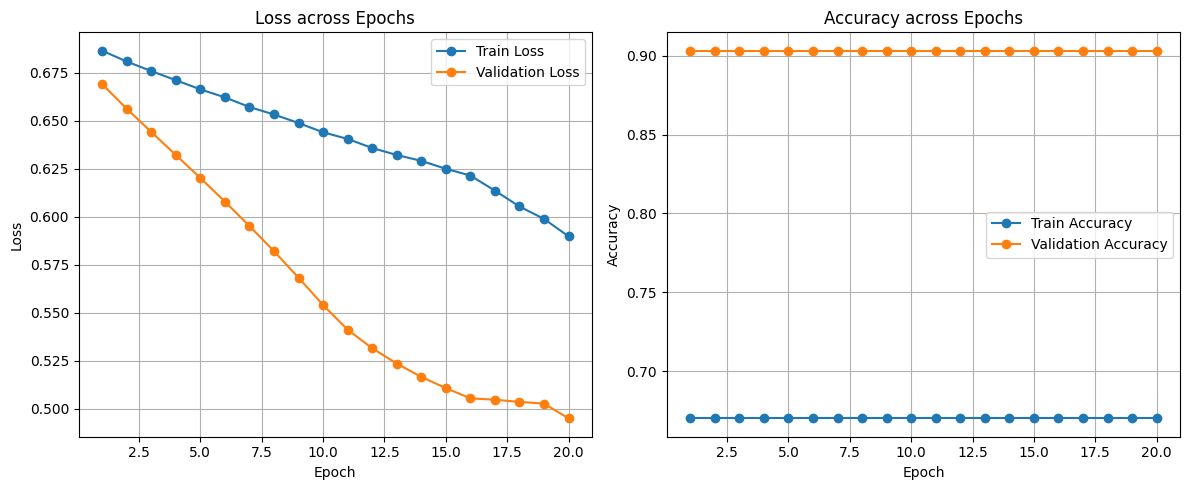

Test Loss: 0.5481, Accuracy: 0.76, F1: 0.8636, Precision: 0.76, Recall: 0.76, ROC AUC: 0.5, AUPR: 0.24
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of TF_target_type labels: 3
Bert Variant: Pubmed_base


Gene name                                            Summary  \
0        HSPA2   Molecular chaperone implicated in a wide vari...   
1         SOX9  This region contains an enhancer that is thoug...   
2        FGF12   Involved in nervous system development and fu...   
3        MKI67  This gene encodes a nuclear protein that is as...   
4      SLC30A3  Predicted to enable zinc ion transmembrane tra...   
...        ...                                                ...   
1317     PRDM6  The protein encoded by this gene is a transcri...   
1318     PCDH1  This gene belongs to the protocadherin subfami...   
1319     CALM1  This gene encodes one of three calmodulin prot...   
1320    MYL12B  The activity of nonmuscle myosin II (see MYH9;...   
1321     TBX20  This gene encodes a Tbox family member. The Tb...   

                TF_target_type  Label  
0                tbx5_indirect      0  
1                tbx5_indirect      0  
2     gata4_tbx5_combo_targets      1  
3                tbx5_indirect      0  
4     gata4_tbx5_combo_targets      1  
...                        ...    ...  
1317             tbx5_indirect      0  
1318             tbx5_indirect      0  
1319             tbx5_indirect      0  
1320  gata4_tbx5_combo_targets      1  
1321  gata4_tbx5_combo_targets      1  

[1322 rows x 4 columns]

Shape of tokens_df before gene2vec:(1322, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1319, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1322, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1319, 7)

#############################
Currently running TF_target_type.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.29 Seconds
Train Loss: 1.0824, Accuracy: 0.4182, F1: 0.4689, Precision: 0.4216, Recall: 0.4182, ROC AUC: 0.4947, AUPR: 0.3893
Val Loss: 1.073, Accuracy: 0.4773, F1: 0.6462, Precision: 0.4773, Recall: 0.4773, ROC AUC: 0.5249, AUPR: 0.4025
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.8 Seconds
Train Loss: 1.0385, Accuracy: 0.5178, F1: 0.6823, Precision: 0.5178, Recall: 0.5178, ROC AUC: 0.4994, AUPR: 0.388
Val Loss: 1.0514, Accuracy: 0.4773, F1: 0.6462, Precision: 0.4773, Recall: 0.4773, ROC AUC: 0.5583, AUPR: 0.4268
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.98 Seconds
Train Loss: 1.0187, Accuracy: 0.5178, F1: 0.6823, Precision: 0.5178, Recall: 0.5178, ROC AUC: 0.5142, AUPR: 0.4003
Val Loss: 1.0506, Accuracy: 0.4773, F1: 0.6462, 

Test Loss: 1.3208, Accuracy: 0.5261, F1: 0.4445, Precision: 0.4283, Recall: 0.5261, ROC AUC: 0.5564, AUPR: 0.4816
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1322, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1319, 7)

#############################
Currently running TF_target_type.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.97 Seconds
Train Loss: 1.0714, Accuracy: 0.5107, F1: 0.6761, Precision: 0.5107, Recall: 0.5107, ROC AUC: 0.4916, AUPR: 0.379
Val Loss: 1.0469, Accuracy: 0.5341, F1: 0.6963, Precision: 0.5341, Recall: 0.5341, ROC AUC: 0.4961, AUPR: 0.4168
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.08 Seconds
Train Loss: 1.0395, Accuracy: 0.5107, F1: 0.6761, Precision: 0.5107, Recall: 0.5107, ROC AUC: 0.5037, AUPR: 0.3882
Val Loss: 1.0148, Accuracy: 0.5341, F1: 0.6963, Precision: 0.5341, Recall: 0.5341, ROC AUC: 0.4956, AUPR: 0.4194
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.89 Seconds
Train Loss: 1.0256, Accuracy: 0.5107, F1: 0.6761, Precision: 0.5107, Recall: 0.5107, ROC AUC: 0.5377, AUPR: 0.4195
Val Loss: 1.0066, Accuracy: 0.5341, F1: 0.6963, Precision: 0.534

Test Loss: 0.9978, Accuracy: 0.5261, F1: 0.5733, Precision: 0.5011, Recall: 0.5261, ROC AUC: 0.5899, AUPR: 0.4849
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1322, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1319, 7)

#############################
Currently running TF_target_type.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.93 Seconds
Train Loss: 1.0846, Accuracy: 0.4502, F1: 0.4829, Precision: 0.4075, Recall: 0.4502, ROC AUC: 0.4824, AUPR: 0.3757
Val Loss: 1.0657, Accuracy: 0.5227, F1: 0.6866, Precision: 0.5227, Recall: 0.5227, ROC AUC: 0.4646, AUPR: 0.3794
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.06 Seconds
Train Loss: 1.0447, Accuracy: 0.5142, F1: 0.6792, Precision: 0.5142, Recall: 0.5142, ROC AUC: 0.4939, AUPR: 0.3884
Val Loss: 1.0283, Accuracy: 0.5227, F1: 0.6866, Precision: 0.5227, Recall: 0.5227, ROC AUC: 0.5076, AUPR: 0.4065
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.07 Seconds
Train Loss: 1.0251, Accuracy: 0.5142, F1: 0.6792, Precision: 0.5142, Recall: 0.5142, ROC AUC: 0.5008, AUPR: 0.3948
Val Loss: 1.0207, Accuracy: 0.5227, F1: 0.686

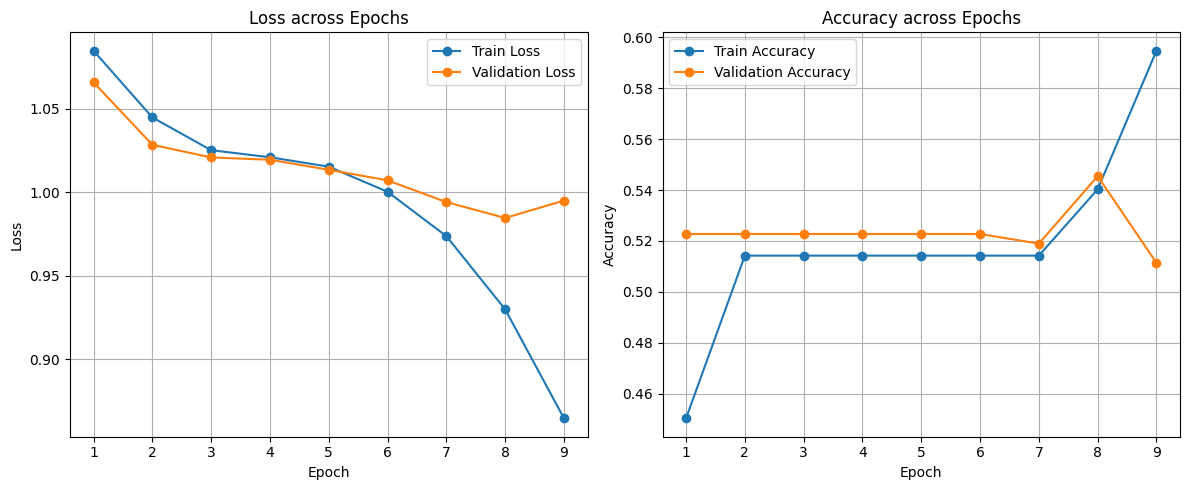

Test Loss: 1.0634, Accuracy: 0.4597, F1: 0.4183, Precision: 0.4053, Recall: 0.4597, ROC AUC: 0.5568, AUPR: 0.4523
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1322, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1319, 7)

#############################
Currently running TF_target_type.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.71 Seconds
Train Loss: 1.0717, Accuracy: 0.5083, F1: 0.674, Precision: 0.5083, Recall: 0.5083, ROC AUC: 0.4862, AUPR: 0.3776
Val Loss: 1.0449, Accuracy: 0.5492, F1: 0.709, Precision: 0.5492, Recall: 0.5492, ROC AUC: 0.5797, AUPR: 0.4655
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.96 Seconds
Train Loss: 1.042, Accuracy: 0.5083, F1: 0.674, Precision: 0.5083, Recall: 0.5083, ROC AUC: 0.493, AUPR: 0.3841
Val Loss: 1.0114, Accuracy: 0.5492, F1: 0.709, Precision: 0.5492, Recall: 0.5492, ROC AUC: 0.5965, AUPR: 0.4832
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.06 Seconds
Train Loss: 1.0294, Accuracy: 0.5083, F1: 0.674, Precision: 0.5083, Recall: 0.5083, ROC AUC: 0.5299, AUPR: 0.4085
Val Loss: 1.0047, Accuracy: 0.5492, F1: 0.709, Preci

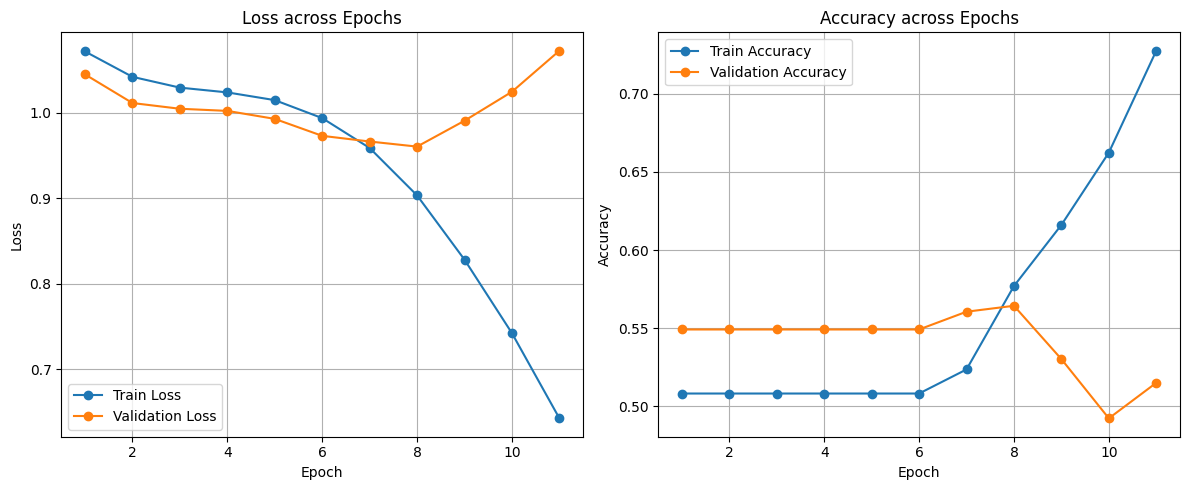

Test Loss: 1.1747, Accuracy: 0.5403, F1: 0.4841, Precision: 0.506, Recall: 0.5403, ROC AUC: 0.6061, AUPR: 0.4992
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(1322, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(1319, 7)

#############################
Currently running TF_target_type.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 13.76 Seconds
Train Loss: 1.0826, Accuracy: 0.5059, F1: 0.4834, Precision: 0.3117, Recall: 0.5059, ROC AUC: 0.4707, AUPR: 0.3658
Val Loss: 1.0591, Accuracy: 0.5095, F1: 0.6751, Precision: 0.5095, Recall: 0.5095, ROC AUC: 0.4982, AUPR: 0.3945
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.03 Seconds
Train Loss: 1.0494, Accuracy: 0.5154, F1: 0.6802, Precision: 0.5154, Recall: 0.5154, ROC AUC: 0.4784, AUPR: 0.3699
Val Loss: 1.0186, Accuracy: 0.5095, F1: 0.6751, Precision: 0.5095, Recall: 0.5095, ROC AUC: 0.5145, AUPR: 0.4015
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([844, 768])
Validation ...
	ET: 14.05 Seconds
Train Loss: 1.0299, Accuracy: 0.5154, F1: 0.6802, Precision: 0.5154, Recall: 0.5154, ROC AUC: 0.4937, AUPR: 0.3941
Val Loss: 1.0084, Accuracy: 0.5095, F1: 0.675

Test Loss: 1.5705, Accuracy: 0.3868, F1: 0.3811, Precision: 0.4408, Recall: 0.3868, ROC AUC: 0.5825, AUPR: 0.4926
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of subcellular_location labels: 3
Bert Variant: Pubmed_base


Gene name                                            Summary  \
0          FES  This gene encodes the human cellular counterpa...   
1        HSPA2   Molecular chaperone implicated in a wide vari...   
2       ZSCAN9  Enables sequencespecific doublestranded DNA bi...   
3      SEPTIN3  This gene belongs to the septin family of GTPa...   
4      TBC1D25  This gene encodes a protein with a TBC domain ...   
...        ...                                                ...   
7698   BHLHE22   Inhibits DNA binding of TCF3/E47 homodimers a...   
7699    RALBP1  RALBP1 plays a role in receptormediated endocy...   
7700     TBX20  This gene encodes a Tbox family member. The Tb...   
7701      DNER  Predicted to enable Notch binding activity. In...   
7702      SOX7  This gene encodes a member of the SOX (SRYrela...   

     Subcellular_location  Label  
0               Cytoplasm      0  
1               Cytoplasm      0  
2                 Nucleus      1  
3               Cytoplasm      0  
4               Cytoplasm      0  
...                   ...    ...  
7698              Nucleus      1  
7699        Cell membrane      2  
7700              Nucleus      1  
7701        Cell membrane      2  
7702              Nucleus      1  

[7703 rows x 4 columns]

Shape of tokens_df before gene2vec:(7703, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(7592, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(7703, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(7592, 7)

#############################
Currently running subcellular_location.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([4858, 768])
Validation ...
	ET: 77.62 Seconds
Train Loss: 0.8801, Accuracy: 0.6204, F1: 0.6078, Precision: 0.6927, Recall: 0.6204, ROC AUC: 0.7838, AUPR: 0.6707
Val Loss: 0.5356, Accuracy: 0.7972, F1: 0.7967, Precision: 0.8063, Recall: 0.7972, ROC AUC: 0.9248, AUPR: 0.8608
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([4858, 768])
Validation ...
	ET: 78.3 Seconds
Train Loss: 0.4736, Accuracy: 0.8117, F1: 0.8121, Precision: 0.8131, Recall: 0.8117, ROC AUC: 0.9295, AUPR: 0.8672
Val Loss: 0.427, Accuracy: 0.8394, F1: 0.8392, Precision: 0.8403, Recall: 0.8394, ROC AUC: 0.9433, AUPR: 0.8977
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([4858, 768])
Validation ...
	ET: 78.82 Seconds
Train Loss: 0.4039, Accuracy: 0.8489, F1: 0.8493, Precision: 0.8508, Recall: 0.8489, ROC AUC: 0.9461, AUPR: 0.8969
Val Loss: 0.4247, Accuracy: 0.8394, F1: 0.83

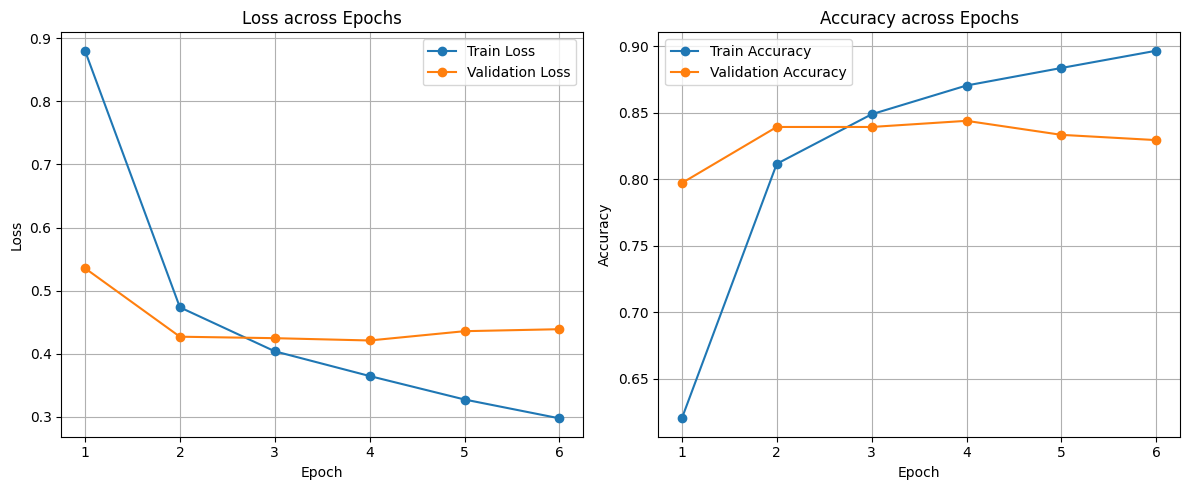

Test Loss: 0.4327, Accuracy: 0.8453, F1: 0.8446, Precision: 0.8453, Recall: 0.8453, ROC AUC: 0.9511, AUPR: 0.9104
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(7703, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(7592, 7)

#############################
Currently running subcellular_location.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([4858, 768])
Validation ...
	ET: 78.18 Seconds
Train Loss: 0.8649, Accuracy: 0.6153, F1: 0.5958, Precision: 0.6724, Recall: 0.6153, ROC AUC: 0.7998, AUPR: 0.6899
Val Loss: 0.5048, Accuracy: 0.8124, F1: 0.8131, Precision: 0.8154, Recall: 0.8124, ROC AUC: 0.9257, AUPR: 0.8705
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([4858, 768])
Validation ...
	ET: 77.4 Seconds
Train Loss: 0.4501, Accuracy: 0.8275, F1: 0.8279, Precision: 0.829, Recall: 0.8275, ROC AUC: 0.9349, AUPR: 0.8721
Val Loss: 0.44, Accuracy: 0.8381, F1: 0.8386, Precision: 0.8412, Recall: 0.8381, ROC AUC: 0.9396, AUPR: 0.8907
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([4858, 768])
Validation ...
	ET: 77.33 Seconds
Train Loss: 0.387, Accuracy: 0.8573, F1: 0.8578, Precision: 0.8597, Recall: 0.8573, ROC AUC: 0.9499, AUPR: 0.9019
Val Loss: 0.4302, Accuracy: 0.8427, F1: 0.8432,

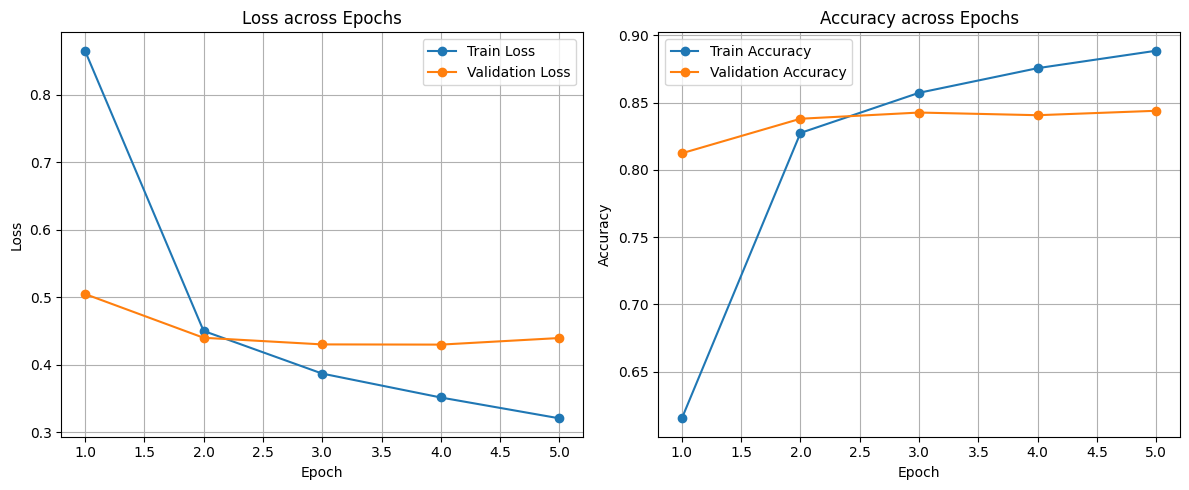

Test Loss: 0.4484, Accuracy: 0.842, F1: 0.8421, Precision: 0.8423, Recall: 0.842, ROC AUC: 0.9446, AUPR: 0.909
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(7703, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(7592, 7)

#############################
Currently running subcellular_location.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 77.07 Seconds
Train Loss: 0.854, Accuracy: 0.6452, F1: 0.6362, Precision: 0.6787, Recall: 0.6452, ROC AUC: 0.8126, AUPR: 0.7053
Val Loss: 0.5415, Accuracy: 0.7833, F1: 0.7835, Precision: 0.7965, Recall: 0.7833, ROC AUC: 0.918, AUPR: 0.8476
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 79.43 Seconds
Train Loss: 0.4393, Accuracy: 0.8382, F1: 0.8386, Precision: 0.8393, Recall: 0.8382, ROC AUC: 0.9379, AUPR: 0.8808
Val Loss: 0.4506, Accuracy: 0.8235, F1: 0.824, Precision: 0.8287, Recall: 0.8235, ROC AUC: 0.9364, AUPR: 0.8797
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 77.53 Seconds
Train Loss: 0.3831, Accuracy: 0.864, F1: 0.8642, Precision: 0.8651, Recall: 0.864, ROC AUC: 0.9517, AUPR: 0.9095
Val Loss: 0.4401, Accuracy: 0.83, F1: 0.8306, P

Test Loss: 0.4603, Accuracy: 0.8395, F1: 0.8402, Precision: 0.8487, Recall: 0.8395, ROC AUC: 0.9427, AUPR: 0.8913
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(7703, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(7592, 7)

#############################
Currently running subcellular_location.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 78.17 Seconds
Train Loss: 0.8492, Accuracy: 0.6178, F1: 0.599, Precision: 0.6495, Recall: 0.6178, ROC AUC: 0.8099, AUPR: 0.7043
Val Loss: 0.5127, Accuracy: 0.8083, F1: 0.8088, Precision: 0.8101, Recall: 0.8083, ROC AUC: 0.9233, AUPR: 0.8577
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 78.15 Seconds
Train Loss: 0.4442, Accuracy: 0.8345, F1: 0.8349, Precision: 0.8359, Recall: 0.8345, ROC AUC: 0.9366, AUPR: 0.8816
Val Loss: 0.4409, Accuracy: 0.8294, F1: 0.8296, Precision: 0.8301, Recall: 0.8294, ROC AUC: 0.9395, AUPR: 0.883
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 78.5 Seconds
Train Loss: 0.3868, Accuracy: 0.8662, F1: 0.8665, Precision: 0.8676, Recall: 0.8662, ROC AUC: 0.9497, AUPR: 0.9054
Val Loss: 0.439, Accuracy: 0.8353, F1: 0.8355

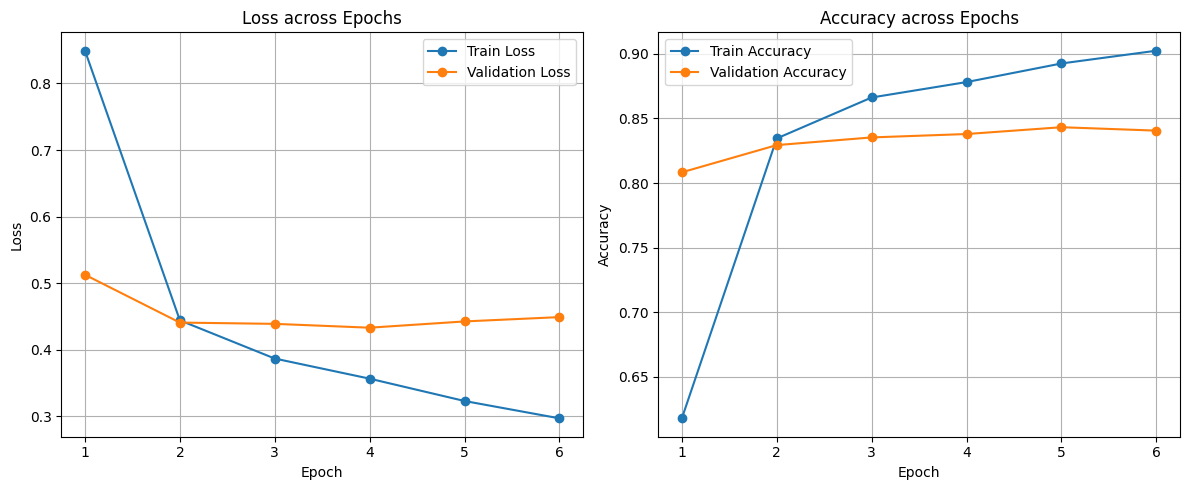

Test Loss: 0.4988, Accuracy: 0.8181, F1: 0.8177, Precision: 0.8179, Recall: 0.8181, ROC AUC: 0.9366, AUPR: 0.8845
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(7703, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(7592, 7)

#############################
Currently running subcellular_location.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 76.37 Seconds
Train Loss: 0.867, Accuracy: 0.6049, F1: 0.5801, Precision: 0.6638, Recall: 0.6049, ROC AUC: 0.8056, AUPR: 0.6958
Val Loss: 0.5171, Accuracy: 0.7997, F1: 0.8, Precision: 0.803, Recall: 0.7997, ROC AUC: 0.9259, AUPR: 0.8585
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 78.12 Seconds
Train Loss: 0.4554, Accuracy: 0.8312, F1: 0.8316, Precision: 0.8326, Recall: 0.8312, ROC AUC: 0.9333, AUPR: 0.8729
Val Loss: 0.4174, Accuracy: 0.8399, F1: 0.84, Precision: 0.8401, Recall: 0.8399, ROC AUC: 0.9462, AUPR: 0.8969
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([4859, 768])
Validation ...
	ET: 77.45 Seconds
Train Loss: 0.396, Accuracy: 0.8568, F1: 0.8571, Precision: 0.8582, Recall: 0.8568, ROC AUC: 0.9485, AUPR: 0.9049
Val Loss: 0.4137, Accuracy: 0.8419, F1: 0.8417, Pr

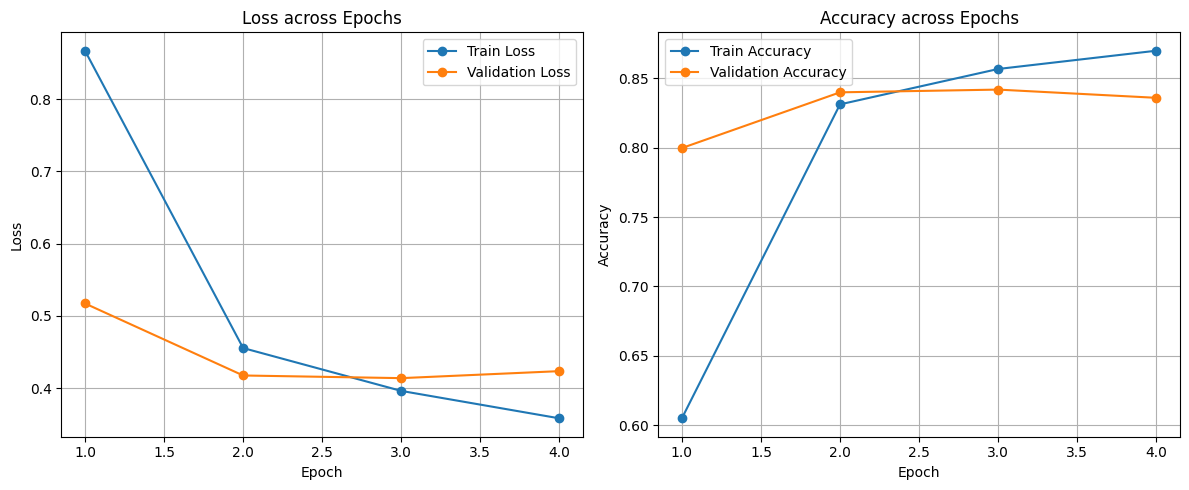

Test Loss: 0.4555, Accuracy: 0.8362, F1: 0.836, Precision: 0.836, Recall: 0.8362, ROC AUC: 0.941, AUPR: 0.8925
model name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
model type: Pubmed_base
Number of phastcons labels: 1
Bert Variant: Pubmed_base


Gene name                                            Summary  \
0              FES  This gene encodes the human cellular counterpa...   
1           SLC7A7  The protein encoded by this gene is the light ...   
2            HSPA2   Molecular chaperone implicated in a wide vari...   
3           ZSCAN9  Enables sequencespecific doublestranded DNA bi...   
4          SEPTIN3  This gene belongs to the septin family of GTPa...   
...            ...                                                ...   
12906        TBX20  This gene encodes a Tbox family member. The Tb...   
12907  IQCJ-SCHIP1  This locus represents naturally occurring read...   
12908        BPY2C  This gene is located in the nonrecombining por...   
12909         DNER  Predicted to enable Notch binding activity. In...   
12910       CXCL14  This antimicrobial gene belongs to the cytokin...   

          Label  
0      0.640952  
1      0.418753  
2      0.424108  
3      0.090192  
4      0.703949  
...         ...  
12906  0.867160  
12907  0.668076  
12908  0.066946  
12909  0.662750  
12910  0.606774  

[12911 rows x 3 columns]

Shape of tokens_df before gene2vec:(12911, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(12716, 7)
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(12911, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(12716, 7)

###############################
Currently running phastcons.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([8137, 768])
Validation ...
	ET: 130.05 Seconds
	Train Loss: 0.047, s_corrcoef: 0.2827, p_corrcoef: 0.1996, MAE: 0.16940000653266907, MSE: 0.04699999839067459, R2: -0.2126
	Val Loss: 0.0247, s_corrcoef: 0.6088, p_corrcoef: 0.6193, MAE: 0.1251000016927719, MSE: 0.024700000882148743, R2: 0.376
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([8137, 768])
Validation ...
	ET: 131.06 Seconds
	Train Loss: 0.0225, s_corrcoef: 0.6248, p_corrcoef: 0.6475, MAE: 0.11869999766349792, MSE: 0.02250000089406967, R2: 0.4192
	Val Loss: 0.0219, s_corrcoef: 0.6643, p_corrcoef: 0.6775, MAE: 0.11630000174045563, MSE: 0.021900000050663948, R2: 0.4465
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([8137, 768])
Validation ...
	ET: 130.78 Seconds
	Train Loss: 0.0202, s_corrcoef: 0.6663, p_corrcoef: 0.6919, MAE: 0.11169999837875366, MSE: 0.02019999921321869, R2: 0

	Test Loss: 0.0218, s_corrcoef: 0.6142, p_corrcoef: 0.6415, MAE: 0.1152999997138977, MSE: 0.021800000220537186, R2: 0.4042
Running bias analysis ...
Median word count: 104.0
Minimum word count: 11
Maximum word count: 1443


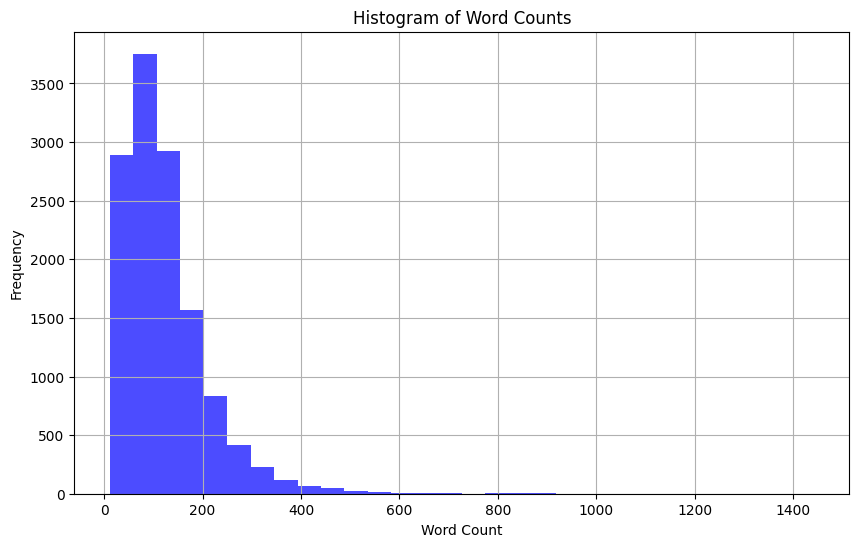

Number of genes with low word count: 138
Number of genes with high word count: 911
Currently running low word count
Shape of tokens_df before gene2vec:(138, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(138, 7)
BIAS ==== word_threshold: 30, count_type: low, s_corrcoef: 0.5605, p_corrcoef: 0.5861, MAE: 0.12639999389648438, MSE: 0.025599999353289604, R2: 0.3364
Currently running high word count
Shape of tokens_df before gene2vec:(911, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(911, 7)
BIAS ==== word_threshold: 30, count_type: high, s_corrcoef: 0.66, p_corrcoef: 0.6803, MAE: 0.10989999771118164, MSE: 0.020400000736117363, R2: 0.4511
Number of genes with low word count: 243
Number of genes with high word count: 911
Currently running low word count
Shape of tokens_df before gene2vec:(243, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(243, 7)
BIAS ==== word_threshold: 40, count_type: low, s_corrcoef: 0.5407, p_corrcoef: 0.573, MAE: 0.12439999729394913, MSE: 0.024399999529123306, R2: 0.3184
Currently running high word count
Shape of tokens_df before gene2vec:(911, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(911, 7)
BIAS ==== word_threshold: 40, count_type: high, s_corrcoef: 0.66, p_corrcoef: 0.6803, MAE: 0.10989999771118164, MSE: 0.020400000736117363, R2: 0.4511
Number of genes with low word count: 365
Number of genes with high word count: 911
Currently running low word count
Shape of tokens_df before gene2vec:(365, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(365, 7)
BIAS ==== word_threshold: 50, count_type: low, s_corrcoef: 0.5469, p_corrcoef: 0.5865, MAE: 0.12720000743865967, MSE: 0.025200000032782555, R2: 0.3336
Currently running high word count
Shape of tokens_df before gene2vec:(911, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(911, 7)
BIAS ==== word_threshold: 50, count_type: high, s_corrcoef: 0.66, p_corrcoef: 0.6803, MAE: 0.10989999771118164, MSE: 0.020400000736117363, R2: 0.4511
Number of genes with low word count: 467
Number of genes with high word count: 911
Currently running low word count
Shape of tokens_df before gene2vec:(467, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(467, 7)
BIAS ==== word_threshold: 60, count_type: low, s_corrcoef: 0.5638, p_corrcoef: 0.5981, MAE: 0.12449999898672104, MSE: 0.024700000882148743, R2: 0.3477
Currently running high word count
Shape of tokens_df before gene2vec:(911, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(911, 7)
BIAS ==== word_threshold: 60, count_type: high, s_corrcoef: 0.66, p_corrcoef: 0.6803, MAE: 0.10989999771118164, MSE: 0.020400000736117363, R2: 0.4511
Number of genes with low word count: 597
Number of genes with high word count: 911
Currently running low word count
Shape of tokens_df before gene2vec:(597, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(597, 7)
BIAS ==== word_threshold: 70, count_type: low, s_corrcoef: 0.5764, p_corrcoef: 0.6144, MAE: 0.12189999967813492, MSE: 0.023800000548362732, R2: 0.369
Currently running high word count
Shape of tokens_df before gene2vec:(911, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(911, 7)
BIAS ==== word_threshold: 70, count_type: high, s_corrcoef: 0.66, p_corrcoef: 0.6803, MAE: 0.10989999771118164, MSE: 0.020400000736117363, R2: 0.4511
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(12911, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(12716, 7)

###############################
Currently running phastcons.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 132.21 Seconds
	Train Loss: 0.0442, s_corrcoef: 0.3138, p_corrcoef: 0.231, MAE: 0.16449999809265137, MSE: 0.044199999421834946, R2: -0.1361
	Val Loss: 0.0238, s_corrcoef: 0.6189, p_corrcoef: 0.6442, MAE: 0.12200000137090683, MSE: 0.023800000548362732, R2: 0.3804
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.25 Seconds
	Train Loss: 0.0229, s_corrcoef: 0.6251, p_corrcoef: 0.6419, MAE: 0.11940000206232071, MSE: 0.02290000021457672, R2: 0.412
	Val Loss: 0.0217, s_corrcoef: 0.6554, p_corrcoef: 0.6801, MAE: 0.11599999666213989, MSE: 0.021700000390410423, R2: 0.436
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.17 Seconds
	Train Loss: 0.0205, s_corrcoef: 0.6677, p_corrcoef: 0.6875, MAE: 0.11240000277757645, MSE: 0.020500000566244125, R2:

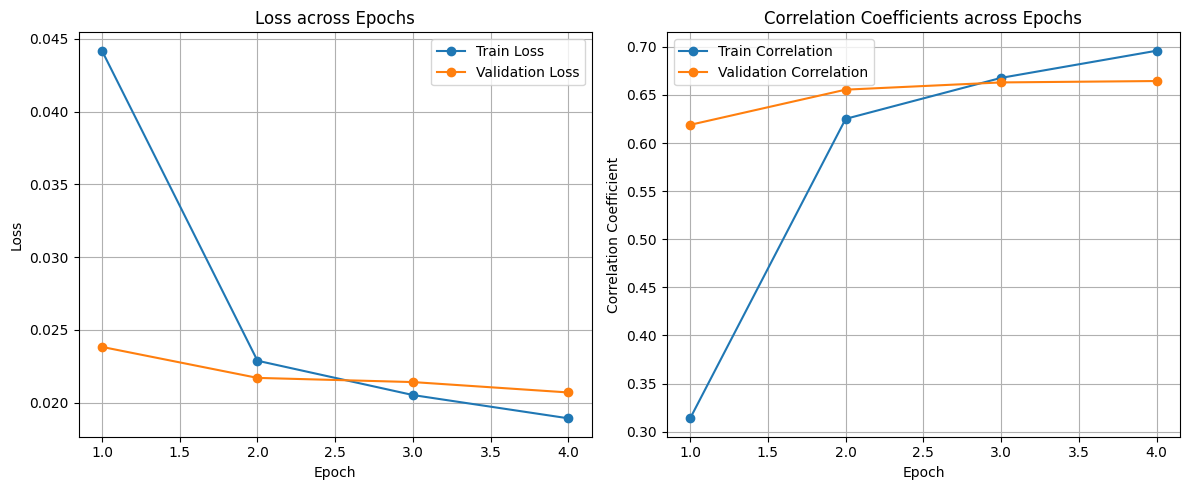

	Test Loss: 0.0207, s_corrcoef: 0.6404, p_corrcoef: 0.6761, MAE: 0.11320000141859055, MSE: 0.02070000022649765, R2: 0.4449
Running bias analysis ...
Median word count: 104.0
Minimum word count: 11
Maximum word count: 1443


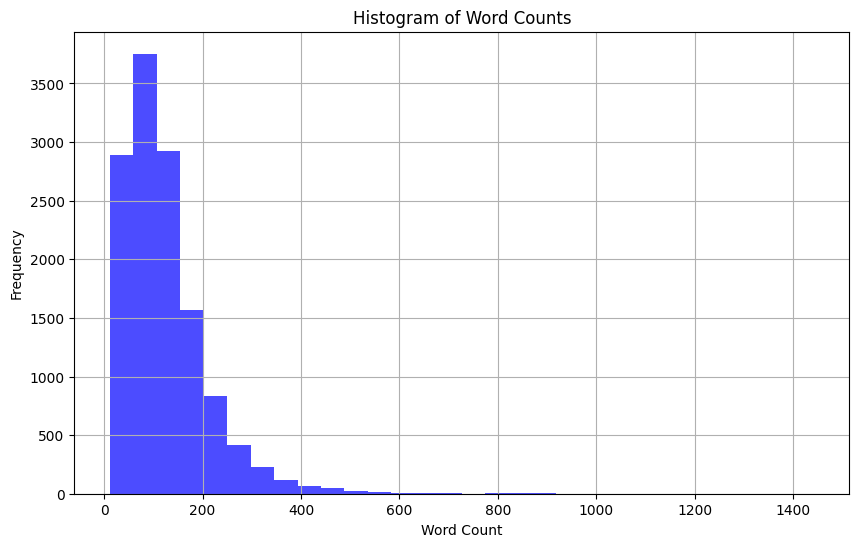

Number of genes with low word count: 139
Number of genes with high word count: 918
Currently running low word count
Shape of tokens_df before gene2vec:(139, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(139, 7)
BIAS ==== word_threshold: 30, count_type: low, s_corrcoef: 0.6192, p_corrcoef: 0.6414, MAE: 0.11540000140666962, MSE: 0.023000000044703484, R2: 0.4016
Currently running high word count
Shape of tokens_df before gene2vec:(918, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(918, 7)
BIAS ==== word_threshold: 30, count_type: high, s_corrcoef: 0.6462, p_corrcoef: 0.6811, MAE: 0.11029999703168869, MSE: 0.01940000057220459, R2: 0.4506
Number of genes with low word count: 233
Number of genes with high word count: 918
Currently running low word count
Shape of tokens_df before gene2vec:(233, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(233, 7)
BIAS ==== word_threshold: 40, count_type: low, s_corrcoef: 0.6465, p_corrcoef: 0.6827, MAE: 0.11969999969005585, MSE: 0.023499999195337296, R2: 0.4523
Currently running high word count
Shape of tokens_df before gene2vec:(918, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(918, 7)
BIAS ==== word_threshold: 40, count_type: high, s_corrcoef: 0.6462, p_corrcoef: 0.6811, MAE: 0.11029999703168869, MSE: 0.01940000057220459, R2: 0.4506
Number of genes with low word count: 356
Number of genes with high word count: 918
Currently running low word count
Shape of tokens_df before gene2vec:(356, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(356, 7)
BIAS ==== word_threshold: 50, count_type: low, s_corrcoef: 0.6367, p_corrcoef: 0.6742, MAE: 0.11550000309944153, MSE: 0.022199999541044235, R2: 0.4425
Currently running high word count
Shape of tokens_df before gene2vec:(918, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(918, 7)
BIAS ==== word_threshold: 50, count_type: high, s_corrcoef: 0.6462, p_corrcoef: 0.6811, MAE: 0.11029999703168869, MSE: 0.01940000057220459, R2: 0.4506
Number of genes with low word count: 459
Number of genes with high word count: 918
Currently running low word count
Shape of tokens_df before gene2vec:(459, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(459, 7)
BIAS ==== word_threshold: 60, count_type: low, s_corrcoef: 0.6244, p_corrcoef: 0.6558, MAE: 0.11720000207424164, MSE: 0.02329999953508377, R2: 0.4178
Currently running high word count
Shape of tokens_df before gene2vec:(918, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(918, 7)
BIAS ==== word_threshold: 60, count_type: high, s_corrcoef: 0.6462, p_corrcoef: 0.6811, MAE: 0.11029999703168869, MSE: 0.01940000057220459, R2: 0.4506
Number of genes with low word count: 593
Number of genes with high word count: 918
Currently running low word count
Shape of tokens_df before gene2vec:(593, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(593, 7)
BIAS ==== word_threshold: 70, count_type: low, s_corrcoef: 0.6389, p_corrcoef: 0.6723, MAE: 0.11599999666213989, MSE: 0.022600000724196434, R2: 0.44
Currently running high word count
Shape of tokens_df before gene2vec:(918, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(918, 7)
BIAS ==== word_threshold: 70, count_type: high, s_corrcoef: 0.6462, p_corrcoef: 0.6811, MAE: 0.11029999703168869, MSE: 0.01940000057220459, R2: 0.4506
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(12911, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(12716, 7)

###############################
Currently running phastcons.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 129.93 Seconds
	Train Loss: 0.0472, s_corrcoef: 0.2792, p_corrcoef: 0.1951, MAE: 0.17069999873638153, MSE: 0.047200001776218414, R2: -0.2221
	Val Loss: 0.0265, s_corrcoef: 0.5657, p_corrcoef: 0.584, MAE: 0.12700000405311584, MSE: 0.026200000196695328, R2: 0.3208
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.7 Seconds
	Train Loss: 0.0222, s_corrcoef: 0.633, p_corrcoef: 0.6527, MAE: 0.11749999970197678, MSE: 0.022199999541044235, R2: 0.426
	Val Loss: 0.0239, s_corrcoef: 0.6162, p_corrcoef: 0.6399, MAE: 0.1193000003695488, MSE: 0.023600000888109207, R2: 0.3876
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.72 Seconds
	Train Loss: 0.0199, s_corrcoef: 0.6745, p_corrcoef: 0.6963, MAE: 0.11110000312328339, MSE: 0.019899999722838402, R2: 

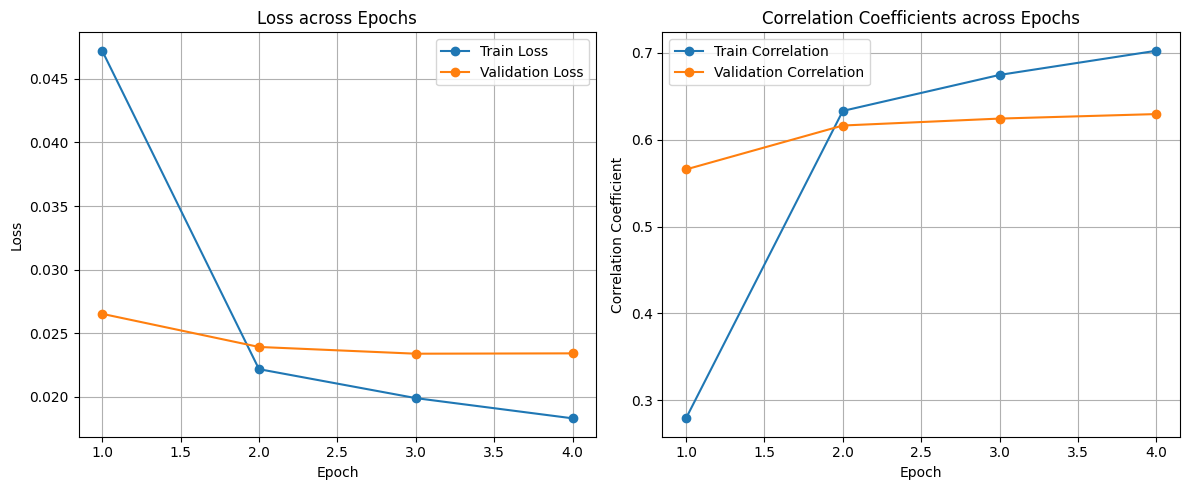

	Test Loss: 0.0225, s_corrcoef: 0.6319, p_corrcoef: 0.6687, MAE: 0.11739999800920486, MSE: 0.022600000724196434, R2: 0.4119
Running bias analysis ...
Median word count: 104.0
Minimum word count: 11
Maximum word count: 1443


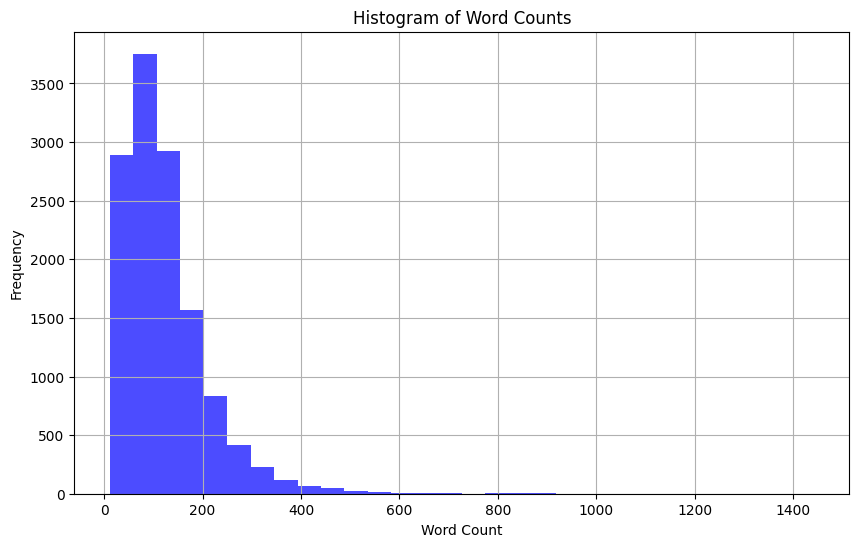

Number of genes with low word count: 125
Number of genes with high word count: 906
Currently running low word count
Shape of tokens_df before gene2vec:(125, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(125, 7)
BIAS ==== word_threshold: 30, count_type: low, s_corrcoef: 0.5207, p_corrcoef: 0.5527, MAE: 0.12430000305175781, MSE: 0.02449999935925007, R2: 0.286
Currently running high word count
Shape of tokens_df before gene2vec:(906, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(906, 7)
BIAS ==== word_threshold: 30, count_type: high, s_corrcoef: 0.6155, p_corrcoef: 0.6515, MAE: 0.11320000141859055, MSE: 0.021400000900030136, R2: 0.373
Number of genes with low word count: 215
Number of genes with high word count: 906
Currently running low word count
Shape of tokens_df before gene2vec:(215, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(215, 7)
BIAS ==== word_threshold: 40, count_type: low, s_corrcoef: 0.5141, p_corrcoef: 0.551, MAE: 0.12559999525547028, MSE: 0.026900000870227814, R2: 0.2783
Currently running high word count
Shape of tokens_df before gene2vec:(906, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(906, 7)
BIAS ==== word_threshold: 40, count_type: high, s_corrcoef: 0.6155, p_corrcoef: 0.6515, MAE: 0.11320000141859055, MSE: 0.021400000900030136, R2: 0.373
Number of genes with low word count: 338
Number of genes with high word count: 906
Currently running low word count
Shape of tokens_df before gene2vec:(338, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(338, 7)
BIAS ==== word_threshold: 50, count_type: low, s_corrcoef: 0.6016, p_corrcoef: 0.6332, MAE: 0.12290000170469284, MSE: 0.025699999183416367, R2: 0.3728
Currently running high word count
Shape of tokens_df before gene2vec:(906, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(906, 7)
BIAS ==== word_threshold: 50, count_type: high, s_corrcoef: 0.6155, p_corrcoef: 0.6515, MAE: 0.11320000141859055, MSE: 0.021400000900030136, R2: 0.373
Number of genes with low word count: 444
Number of genes with high word count: 906
Currently running low word count
Shape of tokens_df before gene2vec:(444, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(444, 7)
BIAS ==== word_threshold: 60, count_type: low, s_corrcoef: 0.6215, p_corrcoef: 0.6516, MAE: 0.1225999966263771, MSE: 0.025299999862909317, R2: 0.3976
Currently running high word count
Shape of tokens_df before gene2vec:(906, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(906, 7)
BIAS ==== word_threshold: 60, count_type: high, s_corrcoef: 0.6155, p_corrcoef: 0.6515, MAE: 0.11320000141859055, MSE: 0.021400000900030136, R2: 0.373
Number of genes with low word count: 598
Number of genes with high word count: 906
Currently running low word count
Shape of tokens_df before gene2vec:(598, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(598, 7)
BIAS ==== word_threshold: 70, count_type: low, s_corrcoef: 0.6372, p_corrcoef: 0.6698, MAE: 0.1185000017285347, MSE: 0.023399999365210533, R2: 0.43
Currently running high word count
Shape of tokens_df before gene2vec:(906, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(906, 7)
BIAS ==== word_threshold: 70, count_type: high, s_corrcoef: 0.6155, p_corrcoef: 0.6515, MAE: 0.11320000141859055, MSE: 0.021400000900030136, R2: 0.373
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(12911, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(12716, 7)

###############################
Currently running phastcons.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.21 Seconds
	Train Loss: 0.0443, s_corrcoef: 0.2897, p_corrcoef: 0.2075, MAE: 0.16539999842643738, MSE: 0.04430000111460686, R2: -0.1532
	Val Loss: 0.0261, s_corrcoef: 0.5725, p_corrcoef: 0.6118, MAE: 0.12690000236034393, MSE: 0.026000000536441803, R2: 0.3079
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.22 Seconds
	Train Loss: 0.0224, s_corrcoef: 0.6261, p_corrcoef: 0.6461, MAE: 0.1185000017285347, MSE: 0.02239999920129776, R2: 0.4175
	Val Loss: 0.0233, s_corrcoef: 0.6278, p_corrcoef: 0.6657, MAE: 0.1193000003695488, MSE: 0.023099999874830246, R2: 0.3852
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 132.23 Seconds
	Train Loss: 0.02, s_corrcoef: 0.6703, p_corrcoef: 0.6926, MAE: 0.11150000244379044, MSE: 0.019999999552965164, R2: 0

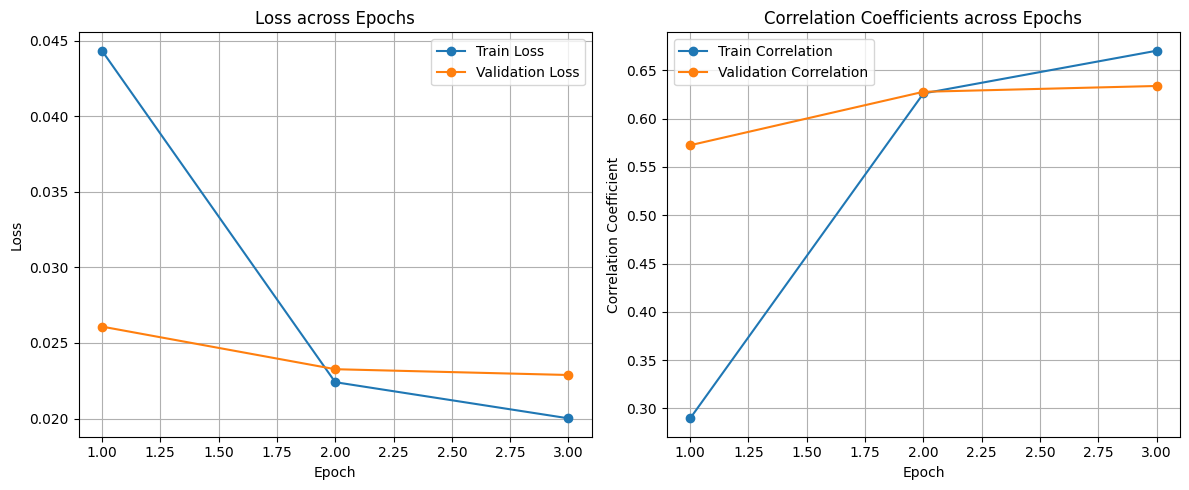

	Test Loss: 0.0242, s_corrcoef: 0.6543, p_corrcoef: 0.6731, MAE: 0.120899997651577, MSE: 0.024299999698996544, R2: 0.3984
Running bias analysis ...
Median word count: 104.0
Minimum word count: 11
Maximum word count: 1443


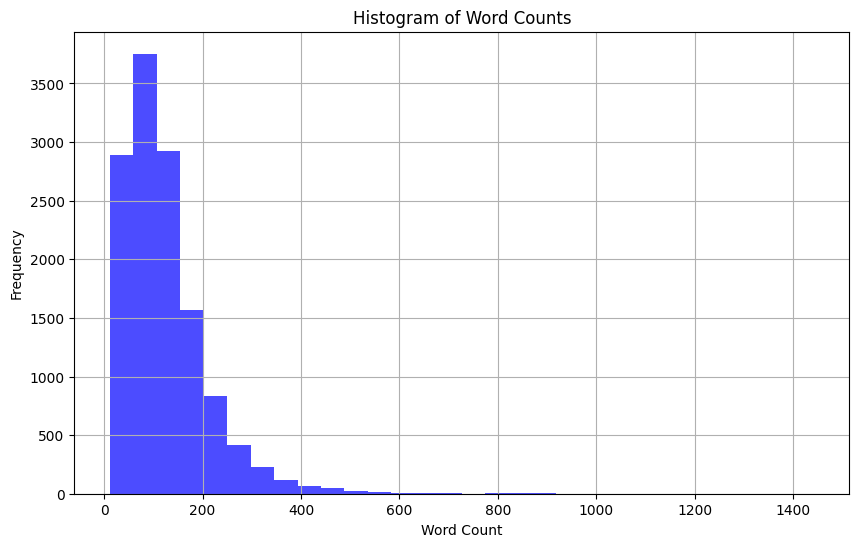

Number of genes with low word count: 164
Number of genes with high word count: 924
Currently running low word count
Shape of tokens_df before gene2vec:(164, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(164, 7)
BIAS ==== word_threshold: 30, count_type: low, s_corrcoef: 0.6021, p_corrcoef: 0.6112, MAE: 0.1298999935388565, MSE: 0.02759999968111515, R2: 0.3216
Currently running high word count
Shape of tokens_df before gene2vec:(924, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(924, 7)
BIAS ==== word_threshold: 30, count_type: high, s_corrcoef: 0.6623, p_corrcoef: 0.6863, MAE: 0.1145000010728836, MSE: 0.022099999710917473, R2: 0.4228
Number of genes with low word count: 258
Number of genes with high word count: 924
Currently running low word count
Shape of tokens_df before gene2vec:(258, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(258, 7)
BIAS ==== word_threshold: 40, count_type: low, s_corrcoef: 0.618, p_corrcoef: 0.638, MAE: 0.12479999661445618, MSE: 0.025299999862909317, R2: 0.3522
Currently running high word count
Shape of tokens_df before gene2vec:(924, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(924, 7)
BIAS ==== word_threshold: 40, count_type: high, s_corrcoef: 0.6623, p_corrcoef: 0.6863, MAE: 0.1145000010728836, MSE: 0.022099999710917473, R2: 0.4228
Number of genes with low word count: 369
Number of genes with high word count: 924
Currently running low word count
Shape of tokens_df before gene2vec:(369, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(369, 7)
BIAS ==== word_threshold: 50, count_type: low, s_corrcoef: 0.6307, p_corrcoef: 0.6557, MAE: 0.12409999966621399, MSE: 0.024800000712275505, R2: 0.374
Currently running high word count
Shape of tokens_df before gene2vec:(924, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(924, 7)
BIAS ==== word_threshold: 50, count_type: high, s_corrcoef: 0.6623, p_corrcoef: 0.6863, MAE: 0.1145000010728836, MSE: 0.022099999710917473, R2: 0.4228
Number of genes with low word count: 470
Number of genes with high word count: 924
Currently running low word count
Shape of tokens_df before gene2vec:(470, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(470, 7)
BIAS ==== word_threshold: 60, count_type: low, s_corrcoef: 0.6391, p_corrcoef: 0.6538, MAE: 0.12460000067949295, MSE: 0.025599999353289604, R2: 0.3711
Currently running high word count
Shape of tokens_df before gene2vec:(924, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(924, 7)
BIAS ==== word_threshold: 60, count_type: high, s_corrcoef: 0.6623, p_corrcoef: 0.6863, MAE: 0.1145000010728836, MSE: 0.022099999710917473, R2: 0.4228
Number of genes with low word count: 585
Number of genes with high word count: 924
Currently running low word count
Shape of tokens_df before gene2vec:(585, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(585, 7)
BIAS ==== word_threshold: 70, count_type: low, s_corrcoef: 0.6377, p_corrcoef: 0.6529, MAE: 0.12559999525547028, MSE: 0.025800000876188278, R2: 0.3679
Currently running high word count
Shape of tokens_df before gene2vec:(924, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(924, 7)
BIAS ==== word_threshold: 70, count_type: high, s_corrcoef: 0.6623, p_corrcoef: 0.6863, MAE: 0.1145000010728836, MSE: 0.022099999710917473, R2: 0.4228
model :Pubmed_base, gene2vec: True
Shape of tokens_df before gene2vec:(12911, 6)


/tmp/ipykernel_1187210/1805357180.py:588: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(12716, 7)

###############################
Currently running phastcons.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 133.65 Seconds
	Train Loss: 0.0466, s_corrcoef: 0.3153, p_corrcoef: 0.2172, MAE: 0.16689999401569366, MSE: 0.04659999907016754, R2: -0.2086
	Val Loss: 0.0254, s_corrcoef: 0.588, p_corrcoef: 0.6043, MAE: 0.12530000507831573, MSE: 0.025100000202655792, R2: 0.3525
best_epoch_num: 1
Epoch 2 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.12 Seconds
	Train Loss: 0.0221, s_corrcoef: 0.6367, p_corrcoef: 0.653, MAE: 0.11699999868869781, MSE: 0.022099999710917473, R2: 0.4264
	Val Loss: 0.0238, s_corrcoef: 0.6251, p_corrcoef: 0.6497, MAE: 0.11999999731779099, MSE: 0.023600000888109207, R2: 0.3914
best_epoch_num: 2
Epoch 3 of 20
-------------------------------
Training ...
torch.Size([8138, 768])
Validation ...
	ET: 131.49 Seconds
	Train Loss: 0.02, s_corrcoef: 0.6743, p_corrcoef: 0.6938, MAE: 0.11079999804496765, MSE: 0.019999999552965164, R2: 

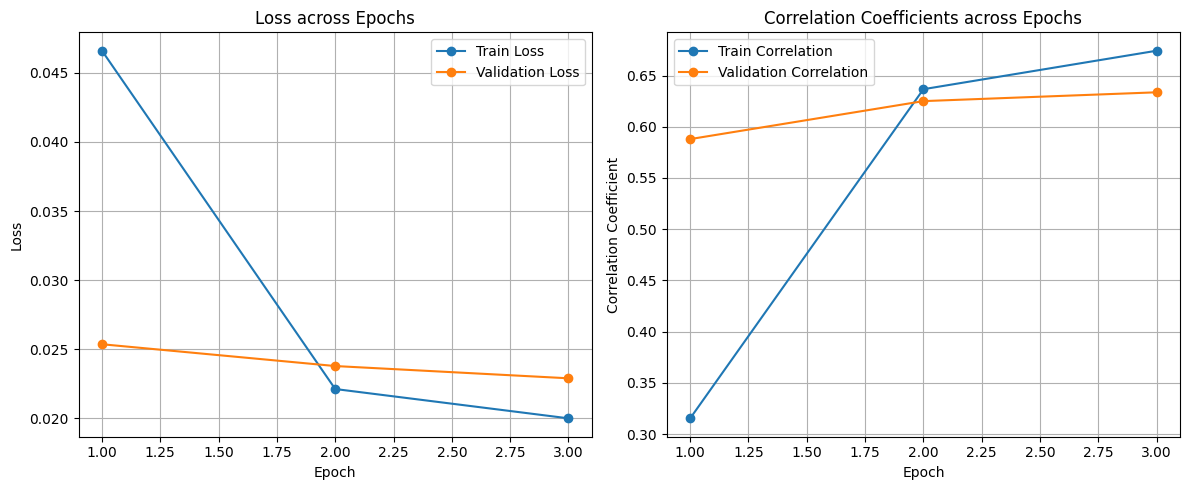

	Test Loss: 0.0225, s_corrcoef: 0.6344, p_corrcoef: 0.6677, MAE: 0.11710000038146973, MSE: 0.02250000089406967, R2: 0.4138
Running bias analysis ...
Median word count: 104.0
Minimum word count: 11
Maximum word count: 1443


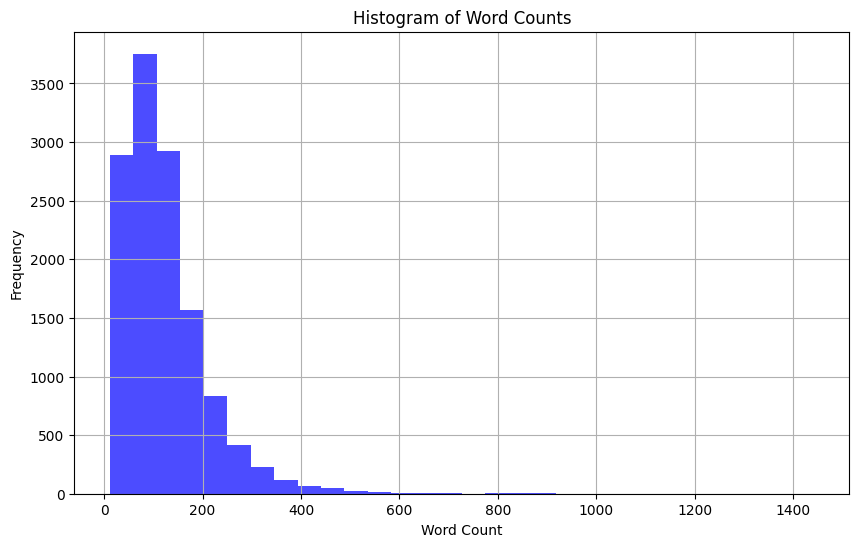

Number of genes with low word count: 143
Number of genes with high word count: 897
Currently running low word count
Shape of tokens_df before gene2vec:(143, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(143, 7)
BIAS ==== word_threshold: 30, count_type: low, s_corrcoef: 0.4641, p_corrcoef: 0.4221, MAE: 0.14149999618530273, MSE: 0.03449999913573265, R2: 0.099
Currently running high word count
Shape of tokens_df before gene2vec:(897, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(897, 7)
BIAS ==== word_threshold: 30, count_type: high, s_corrcoef: 0.6569, p_corrcoef: 0.7058, MAE: 0.10840000212192535, MSE: 0.01899999938905239, R2: 0.4529
Number of genes with low word count: 226
Number of genes with high word count: 897
Currently running low word count
Shape of tokens_df before gene2vec:(226, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(226, 7)
BIAS ==== word_threshold: 40, count_type: low, s_corrcoef: 0.5171, p_corrcoef: 0.4976, MAE: 0.13860000669956207, MSE: 0.031599998474121094, R2: 0.1943
Currently running high word count
Shape of tokens_df before gene2vec:(897, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(897, 7)
BIAS ==== word_threshold: 40, count_type: high, s_corrcoef: 0.6569, p_corrcoef: 0.7058, MAE: 0.10840000212192535, MSE: 0.01899999938905239, R2: 0.4529
Number of genes with low word count: 330
Number of genes with high word count: 897
Currently running low word count
Shape of tokens_df before gene2vec:(330, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(330, 7)
BIAS ==== word_threshold: 50, count_type: low, s_corrcoef: 0.5945, p_corrcoef: 0.596, MAE: 0.12839999794960022, MSE: 0.027799999341368675, R2: 0.3034
Currently running high word count
Shape of tokens_df before gene2vec:(897, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(897, 7)
BIAS ==== word_threshold: 50, count_type: high, s_corrcoef: 0.6569, p_corrcoef: 0.7058, MAE: 0.10840000212192535, MSE: 0.01899999938905239, R2: 0.4529
Number of genes with low word count: 438
Number of genes with high word count: 897
Currently running low word count
Shape of tokens_df before gene2vec:(438, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(438, 7)
BIAS ==== word_threshold: 60, count_type: low, s_corrcoef: 0.5855, p_corrcoef: 0.5944, MAE: 0.12720000743865967, MSE: 0.02710000053048134, R2: 0.3213
Currently running high word count
Shape of tokens_df before gene2vec:(897, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(897, 7)
BIAS ==== word_threshold: 60, count_type: high, s_corrcoef: 0.6569, p_corrcoef: 0.7058, MAE: 0.10840000212192535, MSE: 0.01899999938905239, R2: 0.4529
Number of genes with low word count: 580
Number of genes with high word count: 897
Currently running low word count
Shape of tokens_df before gene2vec:(580, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(580, 7)
BIAS ==== word_threshold: 70, count_type: low, s_corrcoef: 0.5868, p_corrcoef: 0.6089, MAE: 0.12530000507831573, MSE: 0.026399999856948853, R2: 0.3422
Currently running high word count
Shape of tokens_df before gene2vec:(897, 6)
Adding Gene2Vec data ...


/tmp/ipykernel_1187210/1805357180.py:1223: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  Gene2Vec = preoteiin_bert_df.set_index('Gene').T.to_dict('list')


Shape of tokens_df after gene2vec:(897, 7)
BIAS ==== word_threshold: 70, count_type: high, s_corrcoef: 0.6569, p_corrcoef: 0.7058, MAE: 0.10840000212192535, MSE: 0.01899999938905239, R2: 0.4529


In [5]:
import gc
task_names = ['solubility',
    'DosageSensitivity', 
    'BivalentVsLys4',
    'BivalentVsNonMethylated',
    'Tf_range', 
    'TF_target_type',
    'subcellular_location',
    'phastcons'
                ]
task_types = ['classification', 
    'classification', 
    'classification', 
    'classification', 
    'classification', 
    'classification', 
    'classification', 
    'regression'
                ]

for task_name , task_type  in zip(task_names, task_types):
    input_data_path = f'/data/macaulay/GeneLLM2/data/{task_name}.csv'
    analyze(input_data_path, task_type, task_name)

    
    tensor = None
    torch.cuda.empty_cache()
    gc.collect()